## Step 12: Reanalysis of human single-nucleus RNA-seq data from Absinta et al and Schirmer et al

Now we'll reanalyze the human single-nucleus RNA-seq data shown in in Lee et al's Figure 5, which is a combination of two previously published datasets from [Absinta et al 2021 (PMID: 34497421)](https://pubmed.ncbi.nlm.nih.gov/34497421/) and [Schirmer et al 2019 (PMID: 31316211)](https://pubmed.ncbi.nlm.nih.gov/31316211/).

In [1]:
library(Seurat)
library(readxl)
library(ggplot2)
library(ggpubr)
library(dplyr)
library(tidyr)
library(viridis)
library(presto)
library(orthogene)
library(ComplexHeatmap)
library(dendextend)
library(seriation)
library(ggrepel)
library(grid)
library(Matrix)
library(svglite)
library(harmony)
library(cowplot)
library(ggrastr)
setwd('..') # change working directory to 'EpiMemAstros' folder, adjust as needed

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps

First, read in the Seurat object from the previous step:

In [2]:
human <- readRDS('outputs/combined_human_seurat_object.rds')
human

An object of class Seurat 
91241 features across 16276 samples within 2 assays 
Active assay: RNA (61992 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, harmony, umap

This object already contains the UMAP dimension reduction shown in the original manuscript's Figure 5A.

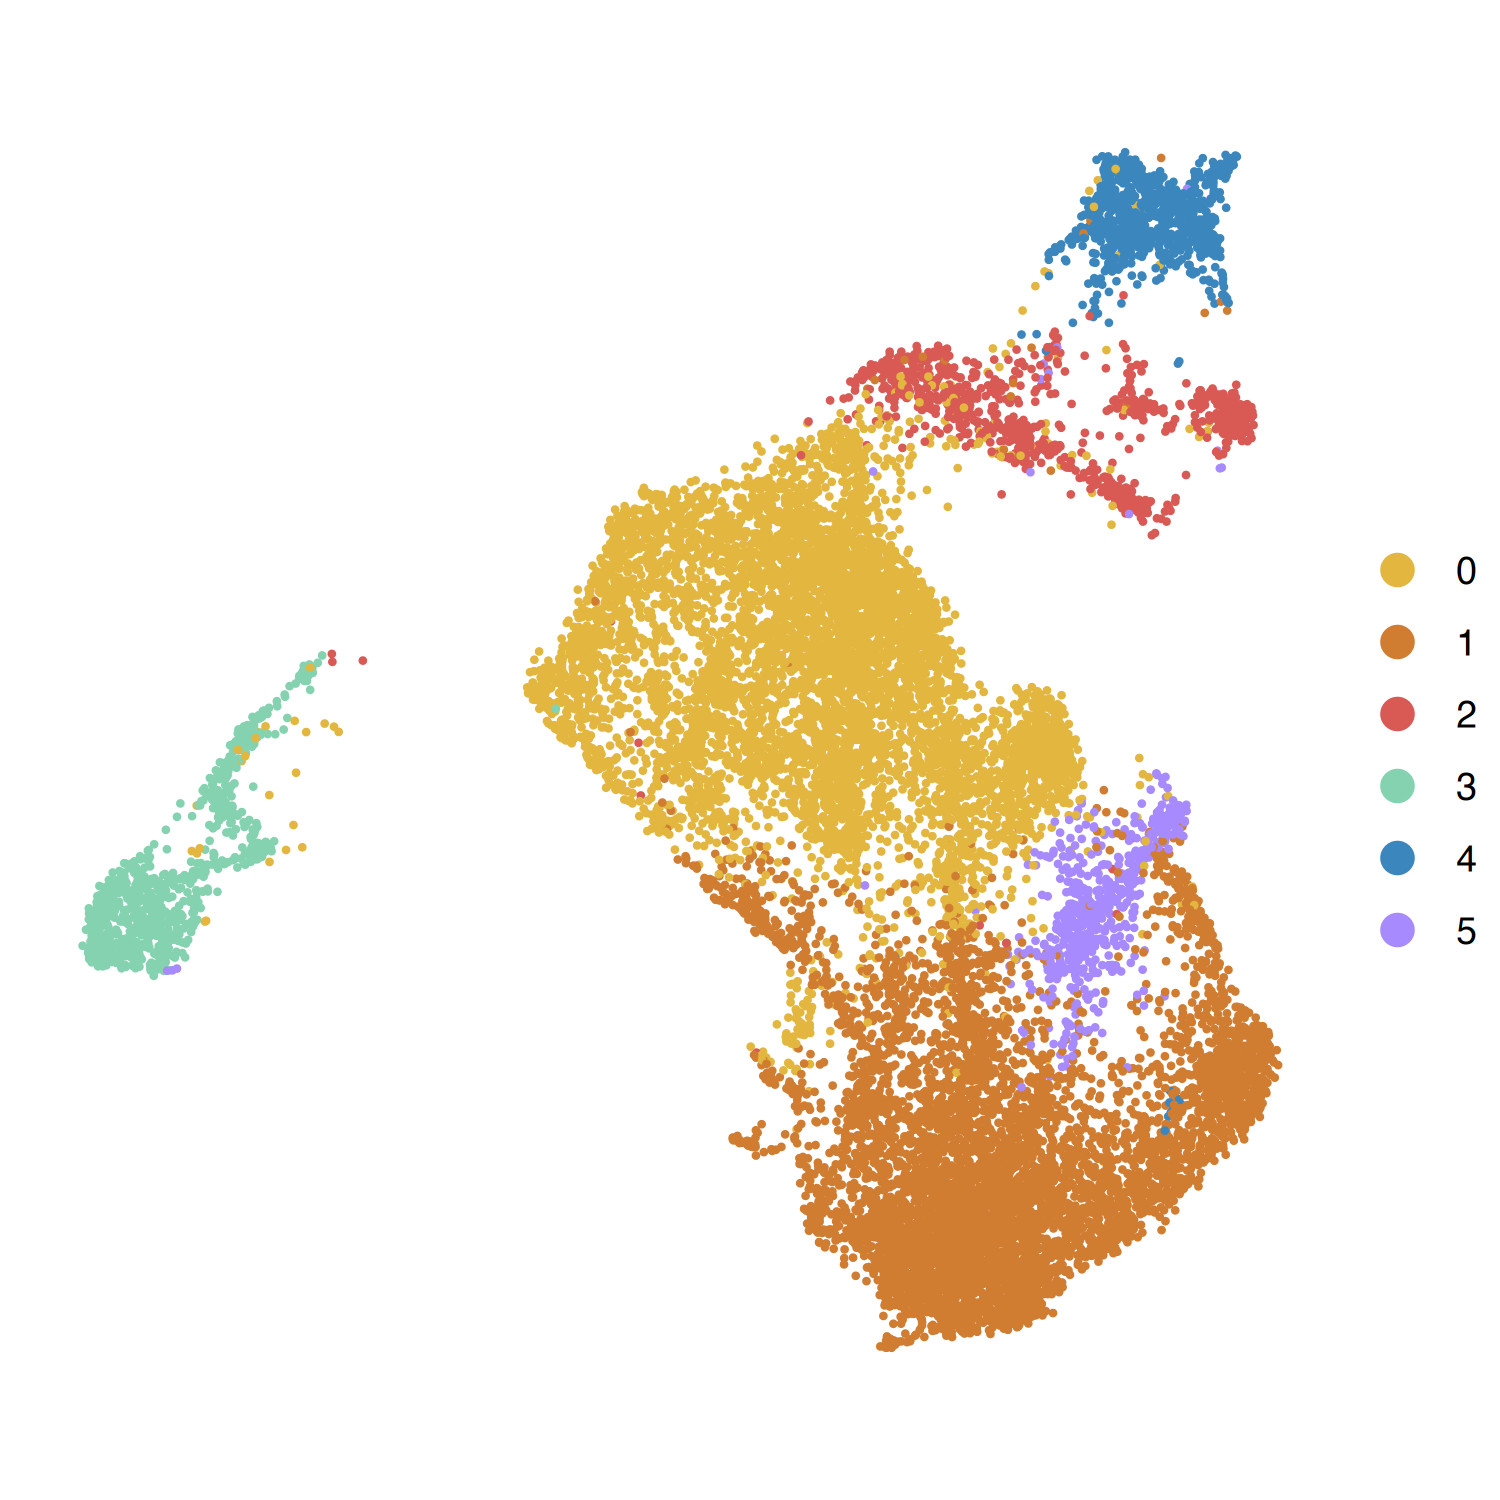

In [3]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res = 300)
image <- DimPlot(human, group.by = "seurat_clusters") + 
    scale_color_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) + labs(title = NULL) + theme_void() + 
    theme(aspect.ratio = 1) + NoLegend()

ggsave(file="outputs/figures/figure4a.png", plot=image, width=5, height=5, dpi = 600)

image <- DimPlot(human, group.by = "seurat_clusters") +  
    scale_color_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) + labs(title = NULL) + theme_void() + 
    theme(aspect.ratio = 1)

legend <- ggpubr::get_legend(image)

ggsave(file="outputs/figures/figure4a_legend.svg", plot=legend, width=5, height=5)

image

Next we'll add a metadata field to the Seurat object which indicates the dataset of origin for each nucleus.

In [4]:
human$source <- data.frame('source' = human$DataSource) %>% 
    mutate(source2 = ifelse(is.na(source), 'Absinta et al 2021', 
                            ifelse(source == 'Schirmer_2019', 'Schirmer et al 2019', source))) %>% .$source2

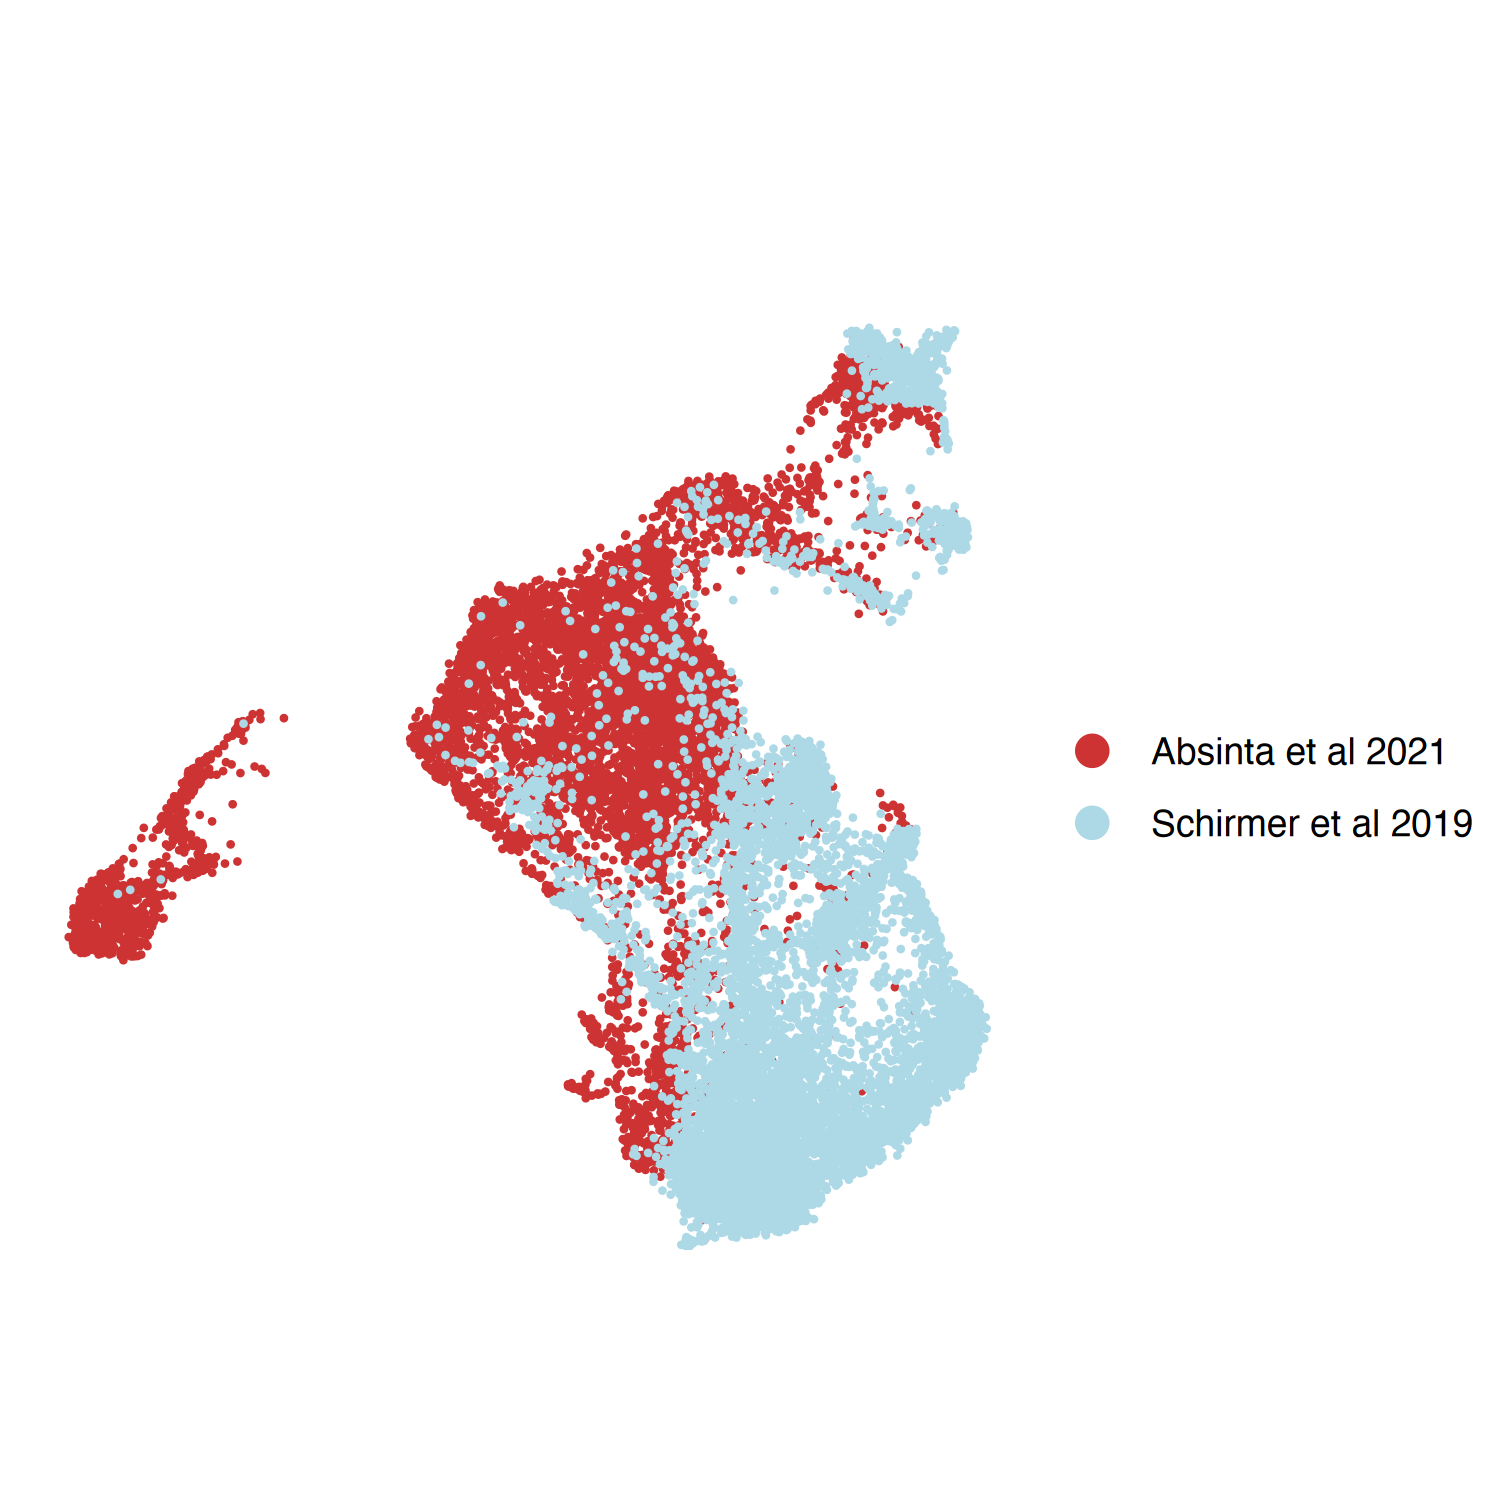

In [5]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res = 300)
image <- DimPlot(human, group.by = "source") + scale_color_manual(values = c('brown3', 'lightblue')) + theme_void() + 
    theme(aspect.ratio = 1) + labs(title = "") + NoLegend()

ggsave(file="outputs/figures/figure4a_dataset.png", plot=image, width=5, height=5, dpi=600)

image <- DimPlot(human, group.by = "source") + scale_color_manual(values = c('brown3', 'lightblue')) + theme_void() + 
    theme(aspect.ratio = 1) + labs(title = "")

legend <- ggpubr::get_legend(image)

ggsave(file="outputs/figures/figure4a_dataset_legend.svg", plot=legend, width=5, height=5)

image

We next calculate several common quality control metrics for each single nucleus and add them as metadata fields in the Seurat object: the percentage of UMIs mapping to the mitochondrial genome, the percentage of UMIs corresponding to ribosomal genes, and the nuclear fraction statistic (which we calculated in Step 11).

In [6]:
human[["percent.mt"]] <- PercentageFeatureSet(object = human, pattern = "^MT-")
human[['percent.ribo']] <- PercentageFeatureSet(human, pattern = '^RP[SL]')

We'll load the nuclear fractions data frames provided in the Zenodo repository. If you obtained the Cell Ranger BAM files and ran the nuclear fraction calculations in Step 11 yourself, replace the first line in the following code cell with the commented out line.

In [7]:
nuc_df = rbind(readRDS('inputs/zenodo/absinta_nuclear_fraction_df.rds'), readRDS('inputs/zenodo/schirmer_nuclear_fraction_df.rds'))
#nuc_df = rbind(readRDS('outputs/absinta_nuclear_fraction_df.rds'), readRDS('outputs/schirmer_nuclear_fraction_df.rds'))

human$nuc_fraction <- nuc_df[colnames(human), ]

Next we calculate enrichment scores for the memory astrocyte Up-Signature and the FIND-seq derived gene signature in each nucleus using the same AddModuleScore method used by Lee et al.

First we read in the Up-Signature gene set from Lee et al's Supplementary Table 3.

In [8]:
signature = read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM4_ESM.xlsx')
up_signature <- signature %>% filter(log2FoldChange > 0) %>% .$gene

Because the original gene signature was composed of mouse genes, we need to create a list of orthologous human genes to evaluate enrichment in this human dataset. We use the `convert_orthologs` function from the `orthogene` package, and retain only one-to-one orthologs between mouse and human.

In [9]:
ortho_genes <- convert_orthologs(up_signature, input_species = "mouse", output_species = 'human', non121_strategy = "drop_both_species")
human_up_signature <- rownames(ortho_genes)

Preparing gene_df.

character format detected.

Converting to data.frame

Extracting genes from input_gene.

1,105 genes extracted.

Converting mouse ==> human orthologs using: gprofiler

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: mouse

Common name mapping found for mouse

1 organism identified from search: mmusculus

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: human

Common name mapping found for human

1 organism identified from search: hsapiens

Checking for genes without orthologs in human.

Extracting genes from input_gene.

1,194 genes extracted.

Extracting genes from ortholog_gene.

1,194 genes extracted.

Dropping 137 NAs of all kinds from ortholog_gene.

Checking for genes without 1:1 orthologs.

Dropping 68 genes that have multiple input_gene per ortholog_gene (many:1).

Dropping 50 genes that have multiple ortholog_gene per input_gene (1:many).

Filterin

We repeat this process for the FIND-seq signature, loading the gene list from Lee et al's Supplementary Table 9.

In [10]:
findseq = read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM10_ESM.xlsx', col_names = FALSE)
findseq = findseq$`...1`
findseq_ortho_genes <- convert_orthologs(findseq, input_species = "mouse", output_species = 'human', non121_strategy = "drop_both_species")
findseq_human <- rownames(findseq_ortho_genes)

New names:
• `` -> `...1`
Preparing gene_df.

character format detected.

Converting to data.frame

Extracting genes from input_gene.

661 genes extracted.

Converting mouse ==> human orthologs using: gprofiler

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: mouse

Common name mapping found for mouse

1 organism identified from search: mmusculus

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: human

Common name mapping found for human

1 organism identified from search: hsapiens

Checking for genes without orthologs in human.

Extracting genes from input_gene.

708 genes extracted.

Extracting genes from ortholog_gene.

708 genes extracted.

Dropping 136 NAs of all kinds from ortholog_gene.

Checking for genes without 1:1 orthologs.

Dropping 23 genes that have multiple input_gene per ortholog_gene (many:1).

Dropping 3 genes that have multiple ortholog_gene per input_gene 

Next, we run AddModuleScore to calculate enrichment of each gene set, and save the gene sets for use in the Step 13 script.

In [11]:
human <- AddModuleScore(human, features = list(human_up_signature, findseq_human), name = 'SIGNATURE')
saveRDS(human_up_signature, 'outputs/human_up_signature.rds')
saveRDS(findseq_human, 'outputs/human_findseq_signature.rds')

Warning message:
“The following features are not present in the object: LY6S, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: ATP5MJ, Metazoa_SRP, LY6S, not searching for symbol synonyms”


Now we evaluate the quality control metrics and enrichment scores across the clusters defined by Lee et al.

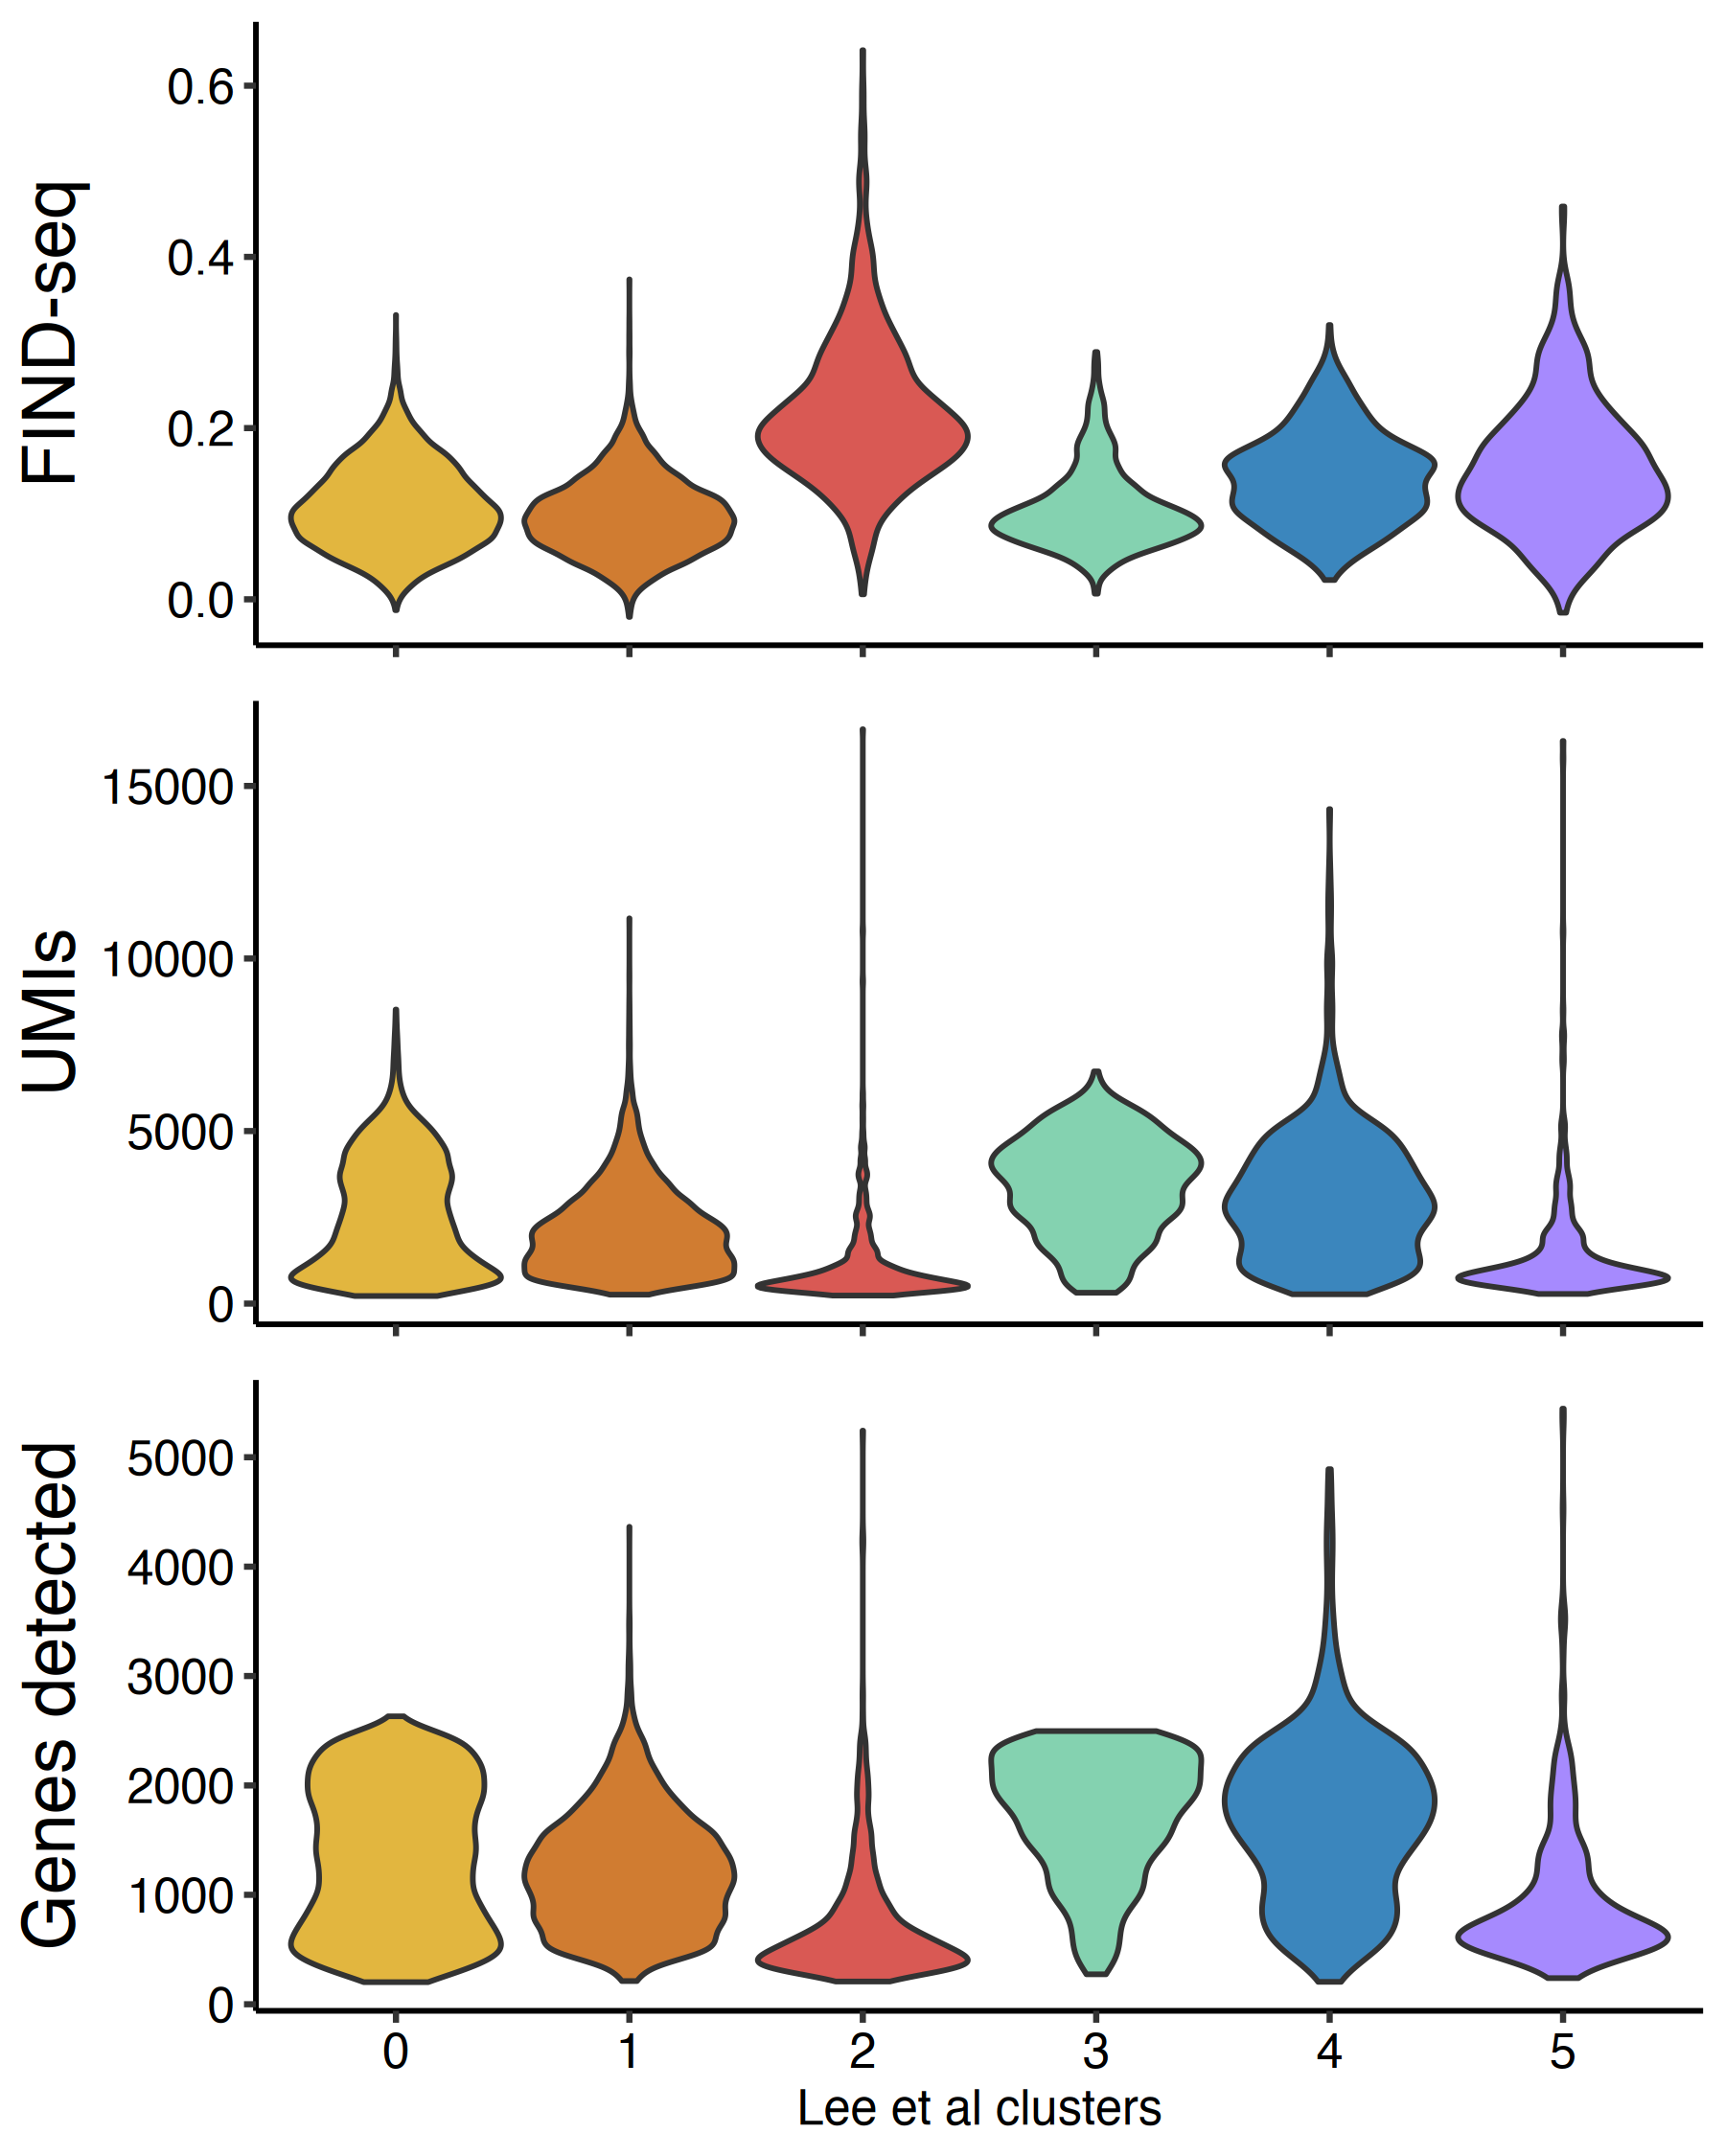

In [12]:
options(repr.plot.width=6, repr.plot.height=7.5, repr.plot.res = 300)

p1 = VlnPlot(human, features="SIGNATURE2", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    theme_pubr() + NoLegend() + 
    labs(x = NULL, y = "FIND-seq", title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

p2 = VlnPlot(human, features="nCount_RNA", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    theme_pubr() + NoLegend() + 
    labs(x = NULL, y = "UMIs", title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

p3 = VlnPlot(human, features="nFeature_RNA", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    theme_pubr() + NoLegend() + 
    labs(x = 'Lee et al clusters', y = "Genes detected", title = NULL) + 
    theme(plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

image = plot_grid(p1, NULL, p2, NULL, p3, ncol = 1, align = 'v', rel_heights = c(1, 0, 1, 0, 1.175))

ggsave(file="outputs/figures/figure4d_part1.svg", plot=image, width=6, height=7.5)

image

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


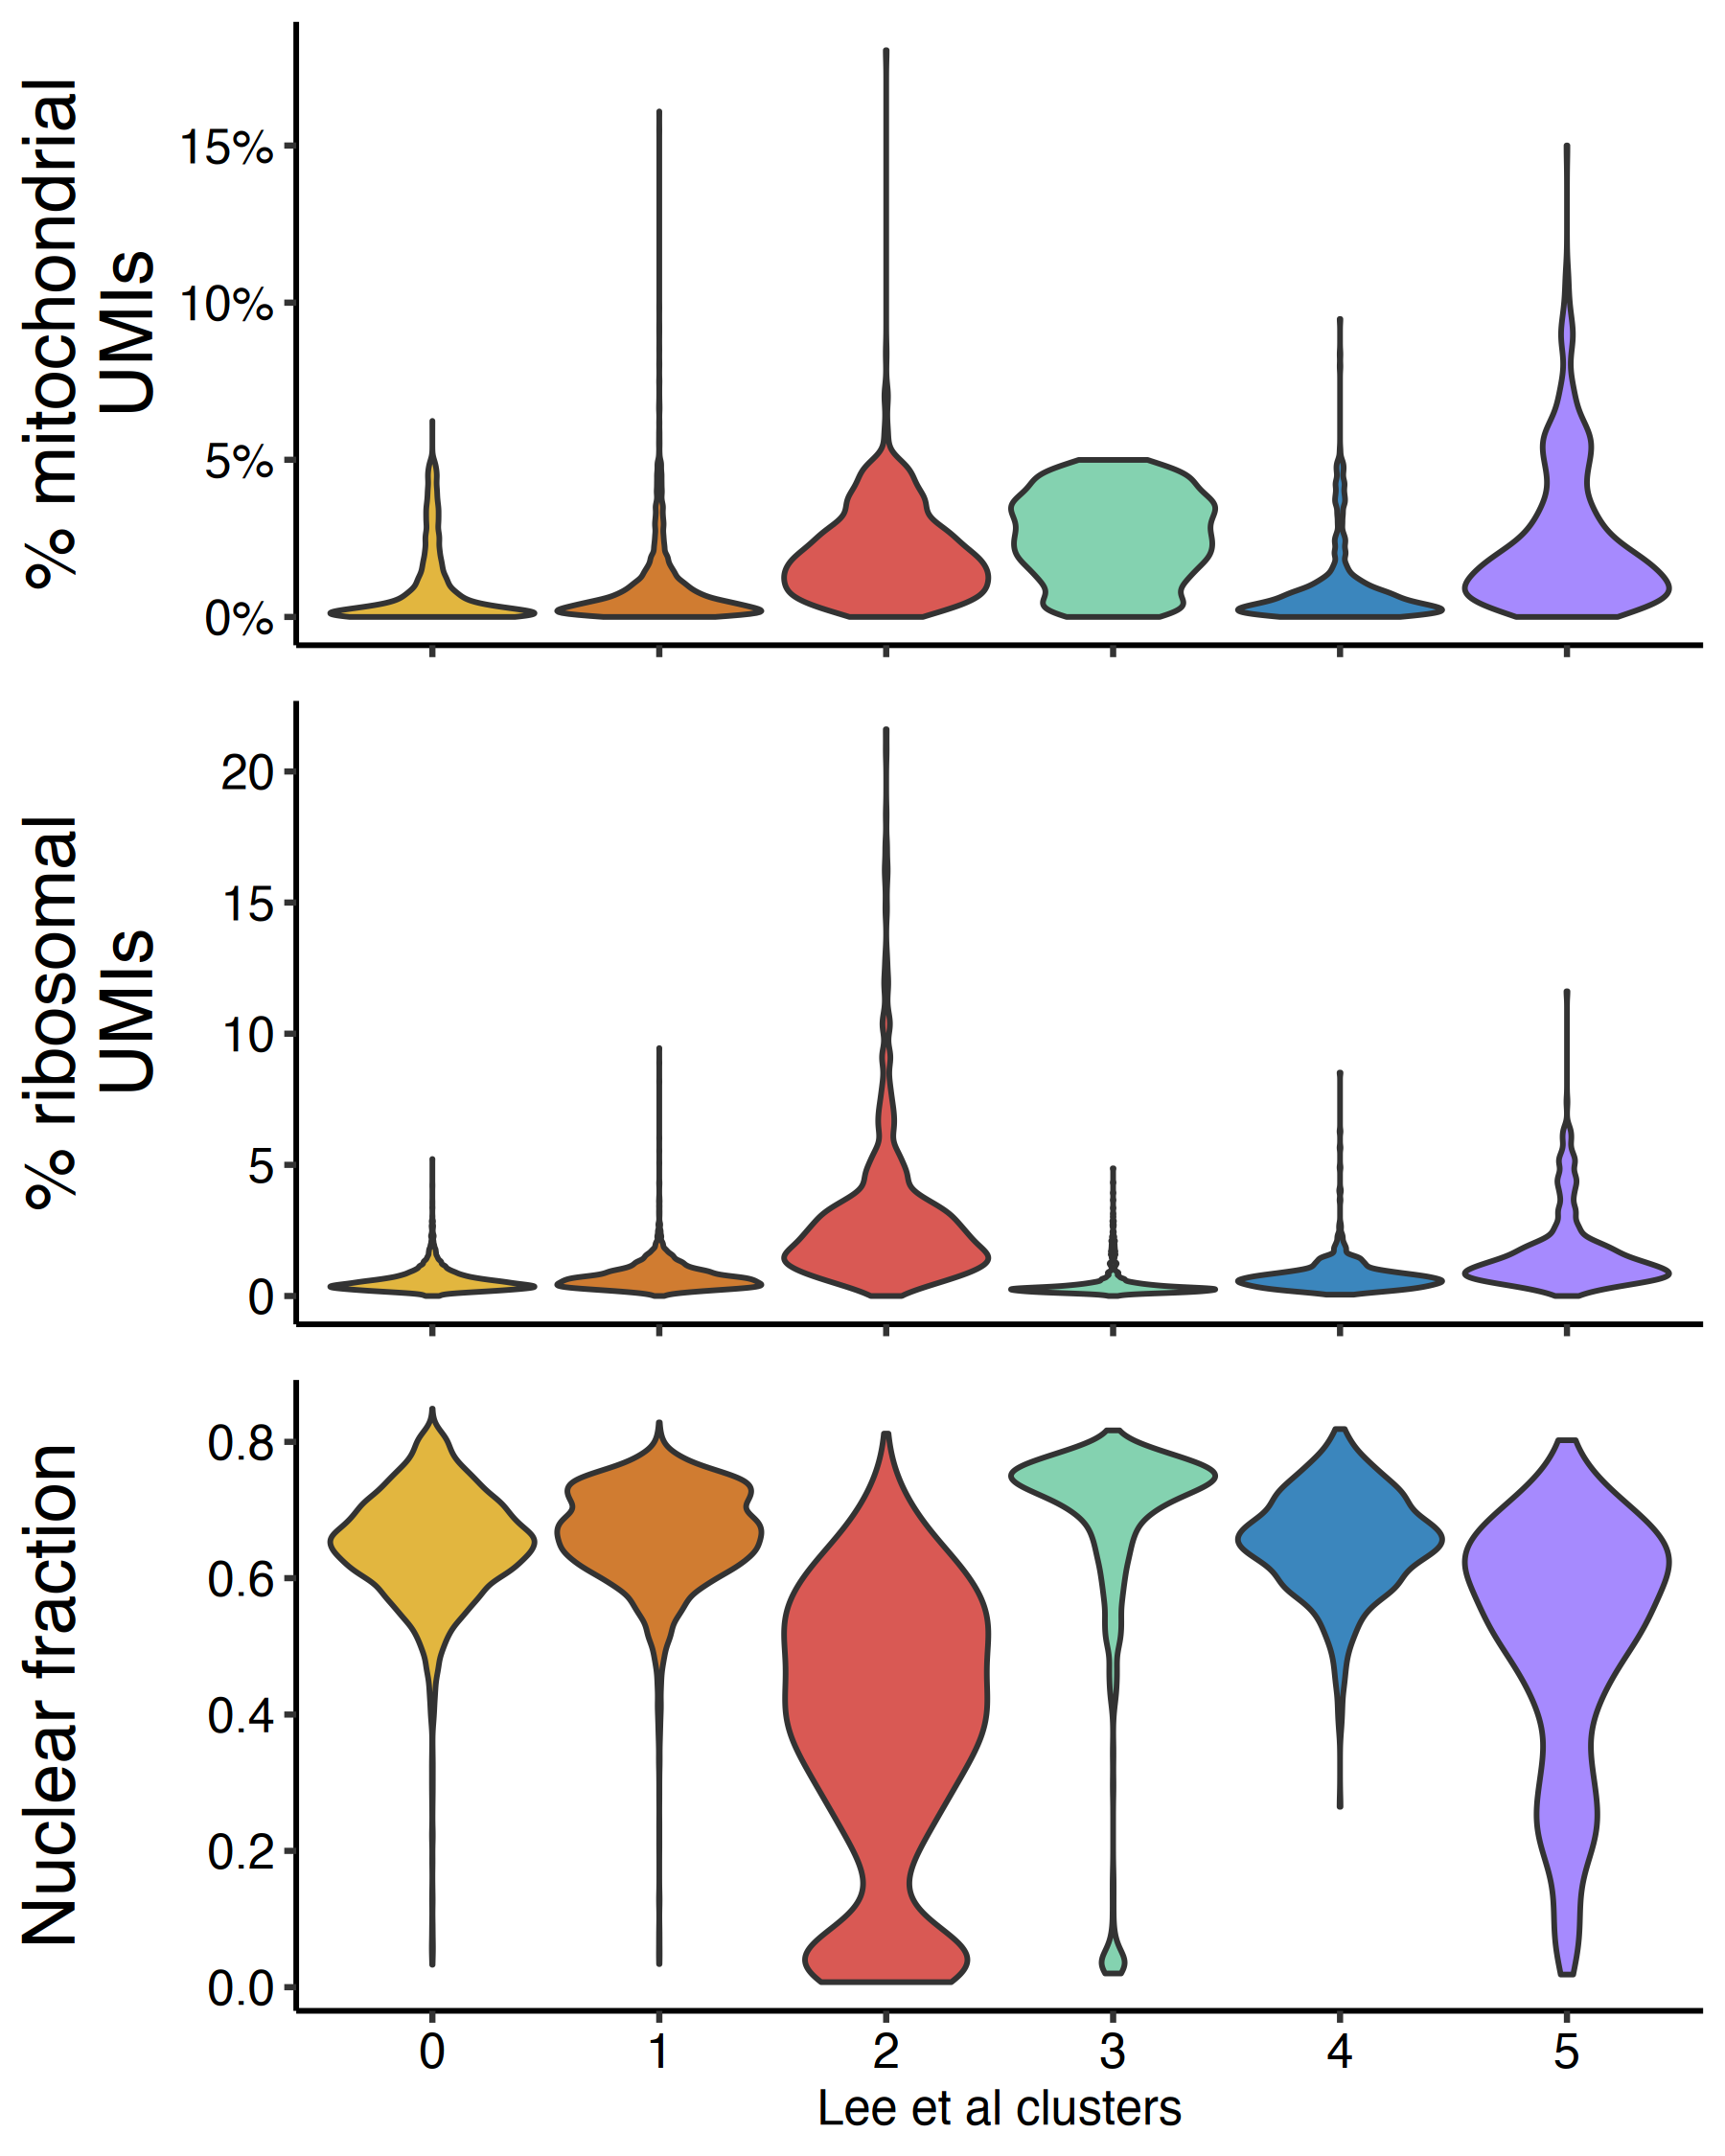

In [13]:
options(repr.plot.width=6, repr.plot.height=7.5, repr.plot.res = 300)

p1 = VlnPlot(human, features="percent.mt", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    theme_pubr() + NoLegend() + 
    scale_y_continuous(labels = function(x) paste0(x, '%')) + 
    labs(x = NULL, y = "% mitochondrial\nUMIs", title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

p2 = VlnPlot(human, features="percent.ribo", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    theme_pubr() + NoLegend() + 
    labs(x = NULL, y = "% ribosomal\nUMIs", title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

p3 = VlnPlot(human, features="nuc_fraction", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    theme_pubr() + NoLegend() + 
    labs(x = 'Lee et al clusters', y = "Nuclear fraction", title = NULL) + 
    theme(plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

image = plot_grid(p1, NULL, p2, NULL, p3, ncol = 1, align = 'v', rel_heights = c(1, 0, 1, 0, 1.175))

ggsave(file="outputs/figures/figure4d_part2.svg", plot=image, width=6, height=7.5)

image

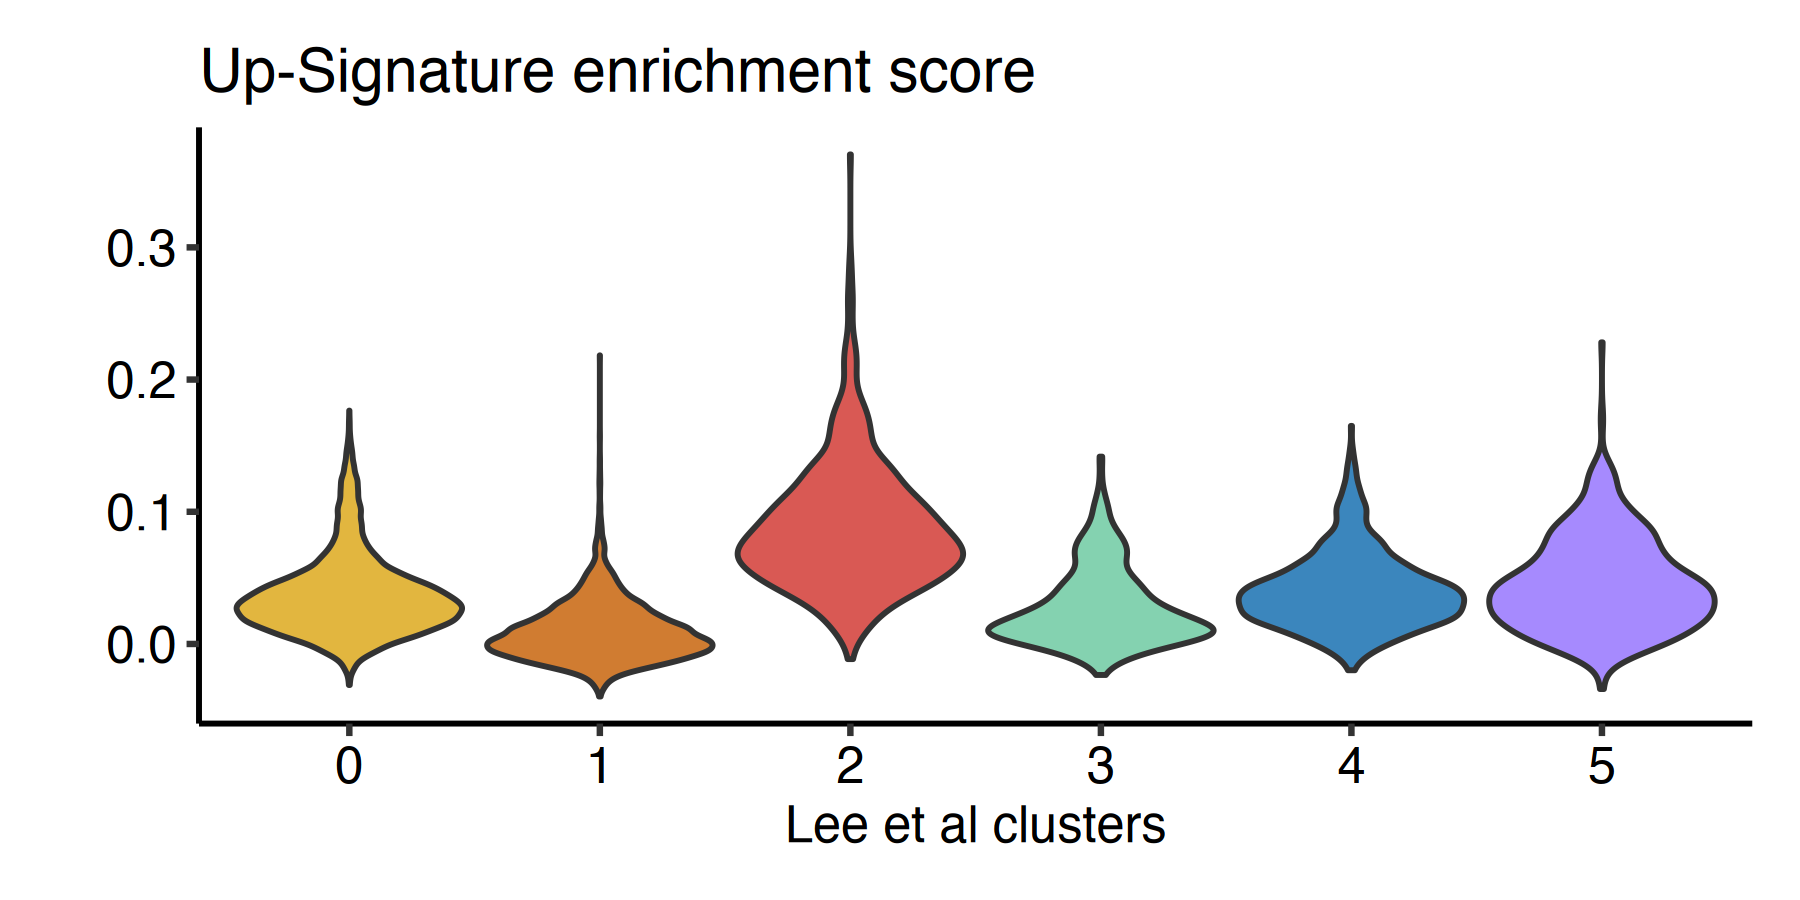

In [14]:
options(repr.plot.width=6, repr.plot.height=3, repr.plot.res = 300)

image = VlnPlot(human, features="SIGNATURE1", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) + 
    theme_pubr() + NoLegend() +
    labs(x = "Lee et al clusters", y = "", title = "Up-Signature enrichment score")

ggsave(file="outputs/figures/supplementary_figure2b.svg", plot=image, width=6, height=3)

image

Now we'll examine what marker genes define each cluster. For this, we'll use the `wilcoxauc` function from the `presto` package to run a fast implementation of the Wilcoxon rank-sum test. Based on [recent work (Moses et al 2023, PMID: 37645732)](https://www.biorxiv.org/content/10.1101/2023.07.20.549945v2) comparing the formulas used to calculate log2-fold changes between Seurat, Scanpy, and other packages, we chose to use the formula from the Scanpy package instead of the one from Seurat.

In [15]:
# geometric mean with static pseudocount (Scanpy log2FC formula)
mean.fxn_geo <- function(x) {
    return(log(x = (expm1(rowMeans(x = x)) + 1e-9), base = 2))
}

# create an empty list for comparing FoldChange calculation results across all clusters
presto_results <- data.frame()

for(i in levels(Idents(human))){ # loop through all clusters
    
    print(paste0("Calculating markers for cluster ", i))
    
    data <- GetAssayData(object = human[['RNA']], layer = "data")
    
    # get cell names for groupings (from differential_expression.R line 1701-1749 [https://github.com/satijalab/seurat/blob/master/R/differential_expression.R#L1701])
    IdentsToCells <- function(
      object,
      ident.1,
      ident.2,
      cellnames.use
    ) {
      #
      if (is.null(x = ident.1)) {
        stop("Please provide ident.1")
      } 
      if (length(x = as.vector(x = ident.1)) > 1 &&
          any(as.character(x = ident.1) %in% cellnames.use)) {
        bad.cells <- cellnames.use[which(x = !as.character(x = ident.1) %in% cellnames.use)]
        if (length(x = bad.cells) > 0) {
          stop(paste0("The following cell names provided to ident.1 are not present in the object: ", paste(bad.cells, collapse = ", ")))
        }
      } else {
        ident.1 <- WhichCells(object = object, idents = ident.1)
      }
      # if NULL for ident.2, use all other cells
      if (length(x = as.vector(x = ident.2)) > 1 &&
          any(as.character(x = ident.2) %in% cellnames.use)) {
        bad.cells <- cellnames.use[which(!as.character(x = ident.2) %in% cellnames.use)]
        if (length(x = bad.cells) > 0) {
          stop(paste0("The following cell names provided to ident.2 are not present in the object: ", paste(bad.cells, collapse = ", ")))
        }
      } else {
        if (is.null(x = ident.2)) {
          ident.2 <- setdiff(x = cellnames.use, y = ident.1)
        } else {
          ident.2 <- WhichCells(object = object, idents = ident.2)
        }
      }
      return(list(cells.1 = ident.1, cells.2 = ident.2))
    }
    
    # extract cell lists using IdentsToCells function
    cells <- IdentsToCells(object = human, ident.1 = i, ident.2 = NULL, cellnames.use = colnames(human))
    cells.1 <- cells$cells.1
    cells.2 <- cells$cells.2

    # order data matrix by group
    data <- data[, c(cells.1, cells.2), drop = FALSE]

    # calculate Scanpy fold change
    data.1 <- mean.fxn_geo(data[, cells.1, drop = FALSE])
    data.2 <- mean.fxn_geo(data[, cells.2, drop = FALSE])
    fc_geo <- (data.1 - data.2)

    # get group labels
    group.info <- data.frame(row.names = c(cells.1, cells.2))
    group.info[cells.1, "group"] <- "Group1"
    group.info[cells.2, "group"] <- "Group2"
    group.info[, "group"] <- factor(x = group.info[, "group"])

     # run presto wilcoxon test
    res <- wilcoxauc(X = data, y = group.info[, "group"])
    res <- res[1:(nrow(x = res)/2),]
    res$cluster <- i
    res$log2FC = fc_geo

    res$padj <- NULL
    res$logFC <- NULL
    res$group <- NULL
    
    res$p_val_adj = p.adjust(
      p =res$pval,
      method = "bonferroni",
      n = nrow(data)
    )
    
    presto_results <- rbind(presto_results, res)

}

# replace zero p-values with more accurate minimum value representable
presto_results = presto_results %>% mutate(p_val_adj = ifelse(p_val_adj == 0, .Machine$double.xmin, p_val_adj))

# save CSV file of results table
write.table(presto_results %>% arrange(cluster, p_val_adj, desc(log2FC)), 'outputs/human_clusters_de_test_results.csv', sep = ',', quote = FALSE, row.names = FALSE, col.names = TRUE)

# save CSV file with the cluster 2 significant DEGs (+-1 log2FC, padj < 0.05)
cluster2_sig_results <- presto_results %>% filter(cluster == '2') %>% filter(abs(log2FC) > 1) %>% filter(p_val_adj < 0.05) %>% arrange(p_val_adj, desc(log2FC))

print("")
print("")
print("")

print("Top Cluster 2 marker genes:")
print(head(cluster2_sig_results %>% filter(log2FC > 1)))

write.table(cluster2_sig_results, 'outputs/human_cluster2_wilcoxon_test_results_DEGs.csv', sep = ',', quote = FALSE, row.names = FALSE, col.names = TRUE)

[1] "Calculating markers for cluster 0"
[1] "Calculating markers for cluster 1"
[1] "Calculating markers for cluster 2"
[1] "Calculating markers for cluster 3"
[1] "Calculating markers for cluster 4"
[1] "Calculating markers for cluster 5"
[1] ""
[1] ""
[1] ""
[1] "Top Cluster 2 marker genes:"
   feature   avgExpr statistic       auc          pval   pct_in    pct_out
1 ARHGAP15 0.5769466   8719772 0.5907398 1.278616e-251 19.50207  1.6131139
2    SKAP1 0.3502998   8234854 0.5578879 1.937223e-226 12.03320  0.5094044
3    IGHGP 0.7043629   8643983 0.5856052 3.493535e-224 18.56846  1.6718913
4      FTL 2.5758619  11508674 0.7796799 4.628288e-224 73.34025 43.2144723
5    PTPRC 0.5574559   8662714 0.5868742 5.665299e-222 18.87967  1.7698537
6      B2M 1.5238714  10400726 0.7046196 1.709150e-219 50.82988 16.3009404
  cluster   log2FC     p_val_adj
1       2 4.876772 7.926395e-247
2       2 5.761931 1.200924e-221
3       2 4.832649 2.165712e-219
4       2 3.057616 2.869168e-219
5       2 4.605

We note that some of the top marker genes for each cluster include canonical marker genes for non-astrocyte cell types.

Centering and scaling data matrix

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


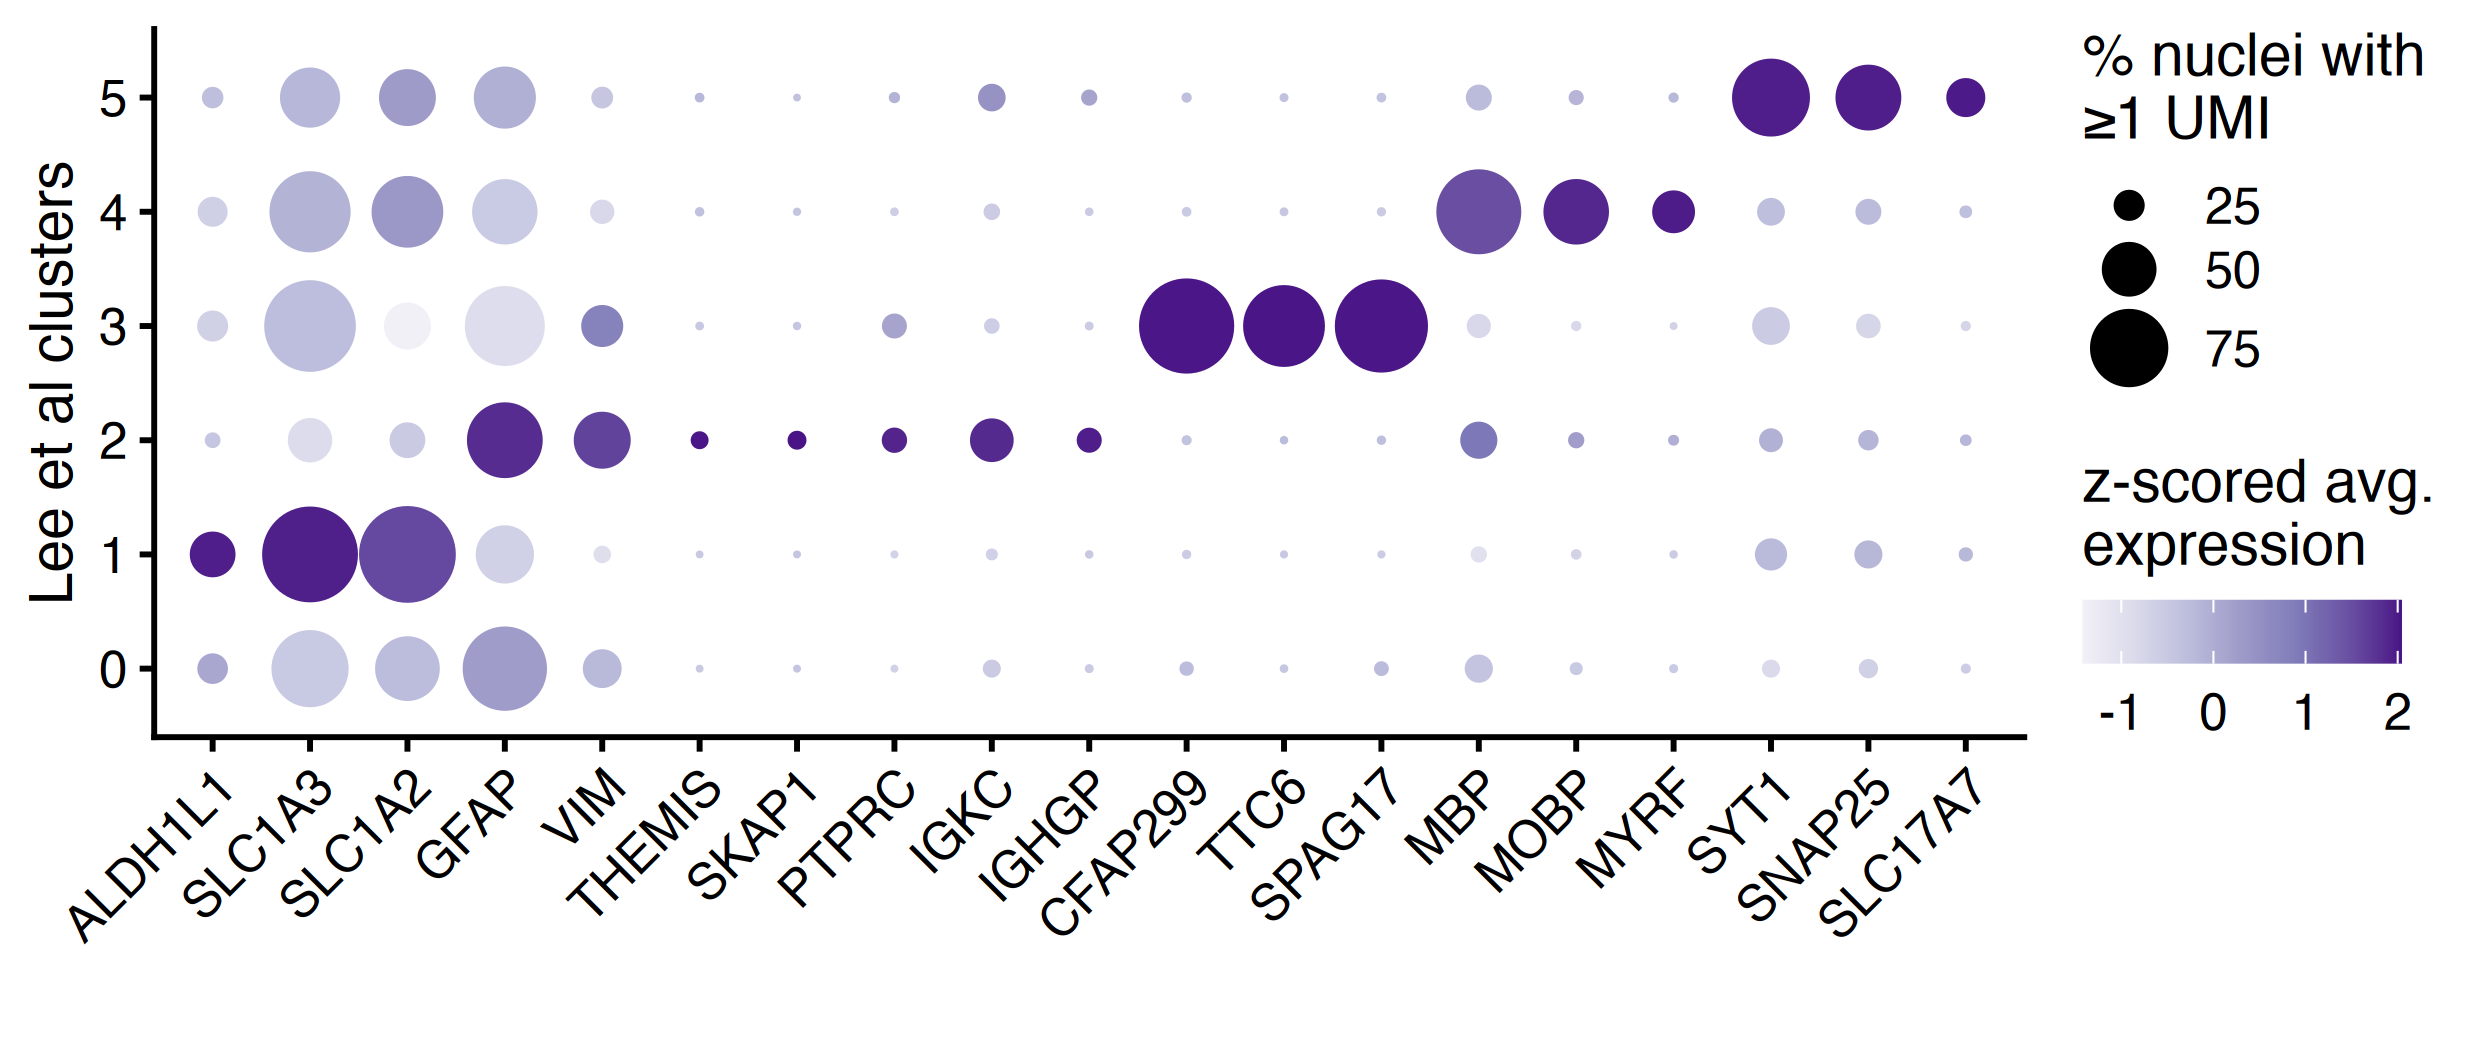

In [16]:
options(repr.plot.width=8.25, repr.plot.height=3.5, repr.plot.res = 300, warn = -1)
human <- ScaleData(human)
image = DotPlot(human, features = c('ALDH1L1', 'SLC1A3', 'SLC1A2',
                            'GFAP', 'VIM',
                            'THEMIS', 'SKAP1', 'PTPRC', 'IGKC','IGHGP', 
                            'CFAP299', 'TTC6', 'SPAG17',
                           'MBP', 'MOBP', 'MYRF',
                            'SYT1', 'SNAP25', 'SLC17A7'
                           ), scale = TRUE,
       dot.scale = 10, group.by = 'seurat_clusters') + 
    labs(x = "", y = "Lee et al clusters", color = "avg. z-score\nexpression") + scale_color_distiller(palette = 'Purples', direction = 1) + 
    scale_y_discrete() + 
    guides(color = guide_colorbar(title = 'z-scored avg.\nexpression', direction = "horizontal", title.position = "top"),
          size = guide_legend(title = "% nuclei with\n≥1 UMI")) + 
    theme(axis.text.x = element_text(angle = 45, hjust=1,face = 'italic'))

ggsave(file="outputs/figures/figure4b.svg", plot=image, width=8.25, height=3.5, dpi = 600)

image

options(warn = 0)

Warning message:
“Removed 61958 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


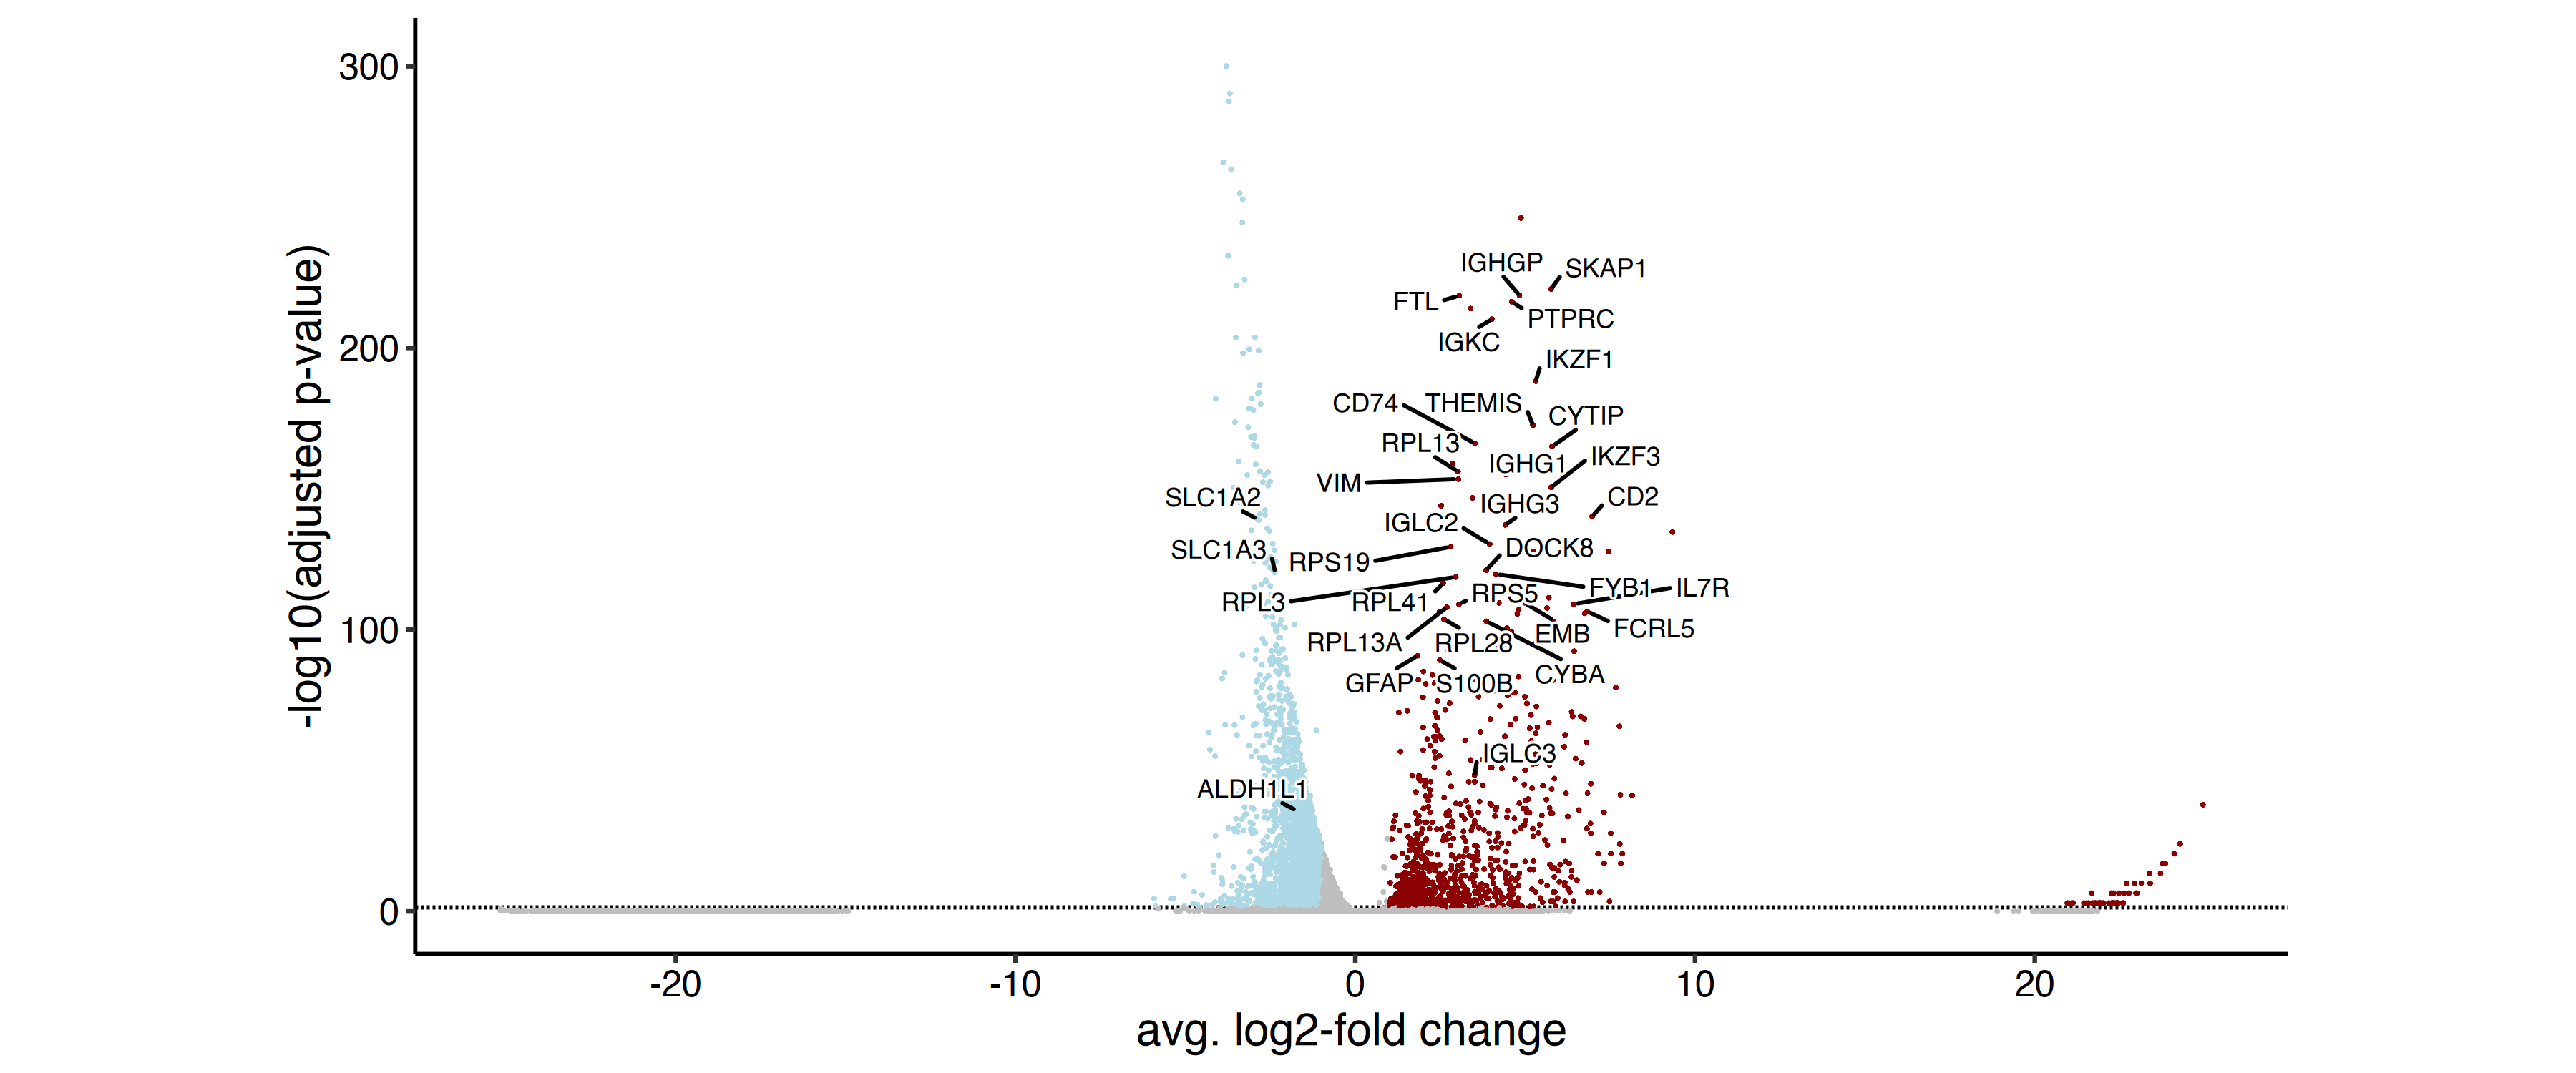

In [17]:
options(repr.plot.width=12, repr.plot.height=5, repr.plot.res = 300)

highlight_genes <- c('VIM', 'GFAP', 'FTL',
                    'IGHGP', 'IGKC', 'IGHG1', 'IGHG3', 'IGLC3', 'IGLC2',
                     'CD74', 'CYBA', 'CYTIP', 'FCRL5',
                     'EMB', 'CD2', 'IL7R', 'IKZF3', 'IKZF1', 'THEMIS', 'PTPRC', 'SKAP1', 'FYB1', 'DOCK8',
                     'RPL13', 'RPL41', 'RPL28', 'RPS19', 'RPL13A', 'RPL3', 'RPS5',
                     'SLC1A3', 'SLC1A2', 'ALDH1L1', 'S100B'
                    )

ggplot(data = presto_results %>% filter(cluster == "2") %>% mutate(label = ifelse(feature %in% highlight_genes, feature, NA)) %>% 
                                                                         mutate(significance = ifelse((p_val_adj < 0.05) & (log2FC > 1), "Up", 
                                                                                              ifelse((p_val_adj < 0.05) & (log2FC < -1), "Down",
                                                                                                    "NS"))), 
       aes(x = log2FC, y = -log10(p_val_adj), label = label, color = significance)) +
  geom_hline(yintercept = -log10(0.05), col = "black", linetype = 'dashed') + 
  rasterize(geom_point(size = 0.1), dpi = 1200) + 
    labs(x = "avg. log2-fold change", y = "-log10(adjusted p-value)") + 
    scale_color_manual(values = c('lightblue', 'gray', 'darkred'), guide = NULL) + 
     geom_text_repel(max.overlaps = Inf, segment.color = "black",
                    nudge_y = 2, min.segment.length = 0, 
                     fontface = 'italic',
                    bg.color = "white",
                     color = "black",
                     size = 3,
                    bg.r = .15) + 
    theme_pubr() + 
  theme(
              axis.title.y = element_text(size = 15),
              axis.title.x = element_text(size=15),
      aspect.ratio = 0.5
            )

Warning message:
“Removed 15124 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 61968 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 15124 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 61968 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


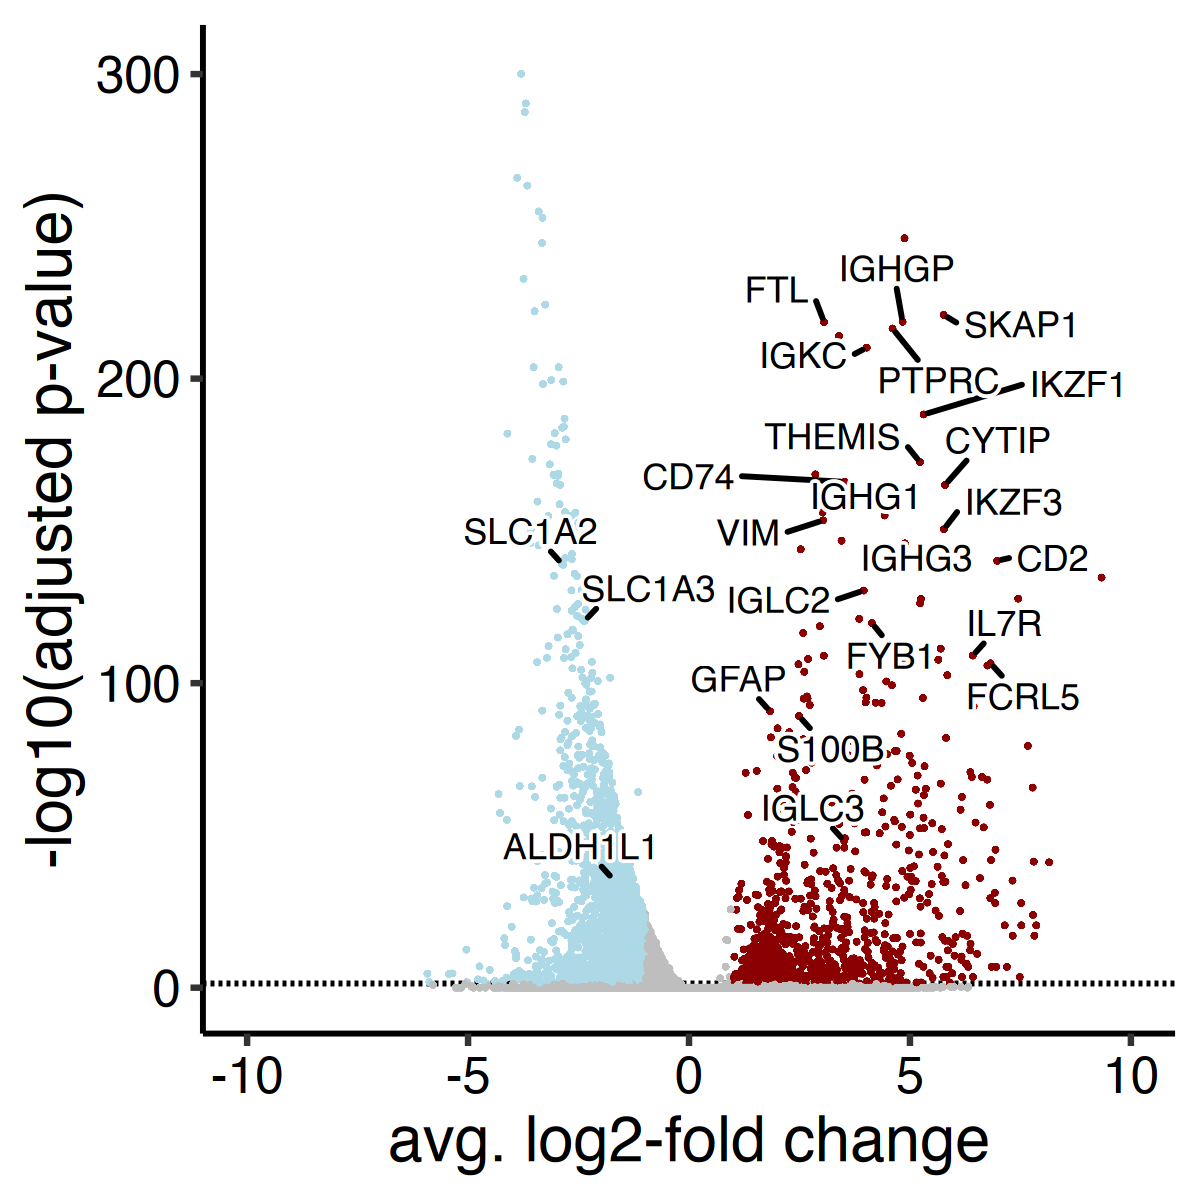

In [18]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res = 300)

highlight_genes <- c('VIM', 'GFAP', 'FTL',
                    'IGHGP', 'IGKC', 'IGHG1', 'IGHG3', 'IGLC3', 'IGLC2',
                     'CD74', 'CYTIP', 'FCRL5',
                     'CD2', 'IL7R', 'IKZF3', 'IKZF1', 'THEMIS', 'PTPRC', 'SKAP1', 'FYB1',
                     'SLC1A3', 'SLC1A2', 'ALDH1L1', 'S100B'
                    )

image = ggplot(data = presto_results %>% filter(cluster == "2") %>% mutate(label = ifelse(feature %in% highlight_genes, feature, NA)) %>% 
                                                                         mutate(significance = ifelse((p_val_adj < 0.05) & (log2FC > 1), "Up", 
                                                                                              ifelse((p_val_adj < 0.05) & (log2FC < -1), "Down",
                                                                                                    "NS"))), 
       aes(x = log2FC, y = -log10(p_val_adj), label = label, color = significance)) +
  geom_hline(yintercept = -log10(0.05), col = "black", linetype = 'dashed') + 
  rasterize(geom_point(size = 0.1), dpi = 1200) + 
    labs(x = "avg. log2-fold change", y = "-log10(adjusted p-value)") + 
    scale_color_manual(values = c('lightblue', 'gray', 'darkred'), guide = NULL) + 
     geom_text_repel(max.overlaps = Inf, segment.color = "black",
                    nudge_y = 1, min.segment.length = 0, 
                     fontface = 'italic',
                    bg.color = "white",
                     color = "black",
                     size = 3,
                    bg.r = .15) + 
    scale_x_continuous(limits = c(-10, 10)) + 
    theme_pubr() + 
  theme(
              axis.title.y = element_text(size = 15),
              axis.title.x = element_text(size=15)
            )

ggsave(file="outputs/figures/figure4c.svg", plot=image, width=4, height=4)

image

Because Cluster 2 is marked by higher expression of T cell and B cell marker genes as well as *GFAP* and *VIM*, we next examined whether these genes were expressed across all nuclei in this cluster or by only a subset. To do this, we plot expression of the top 50 Cluster 2 marker genes ordered by p-value across all Cluster 2 nuclei in a heatmap.

With random ordering of the nuclei in the heatmap columns, the plot would be more difficult to interpret and subgroups may not be easily identifiable. In order to group transcriptomically similar nuclei together in the plot, we cluster the nuclei based on Euclidean distance in PCA space.

In [19]:
features = (cluster2_sig_results %>% filter(log2FC > 1))[1:50,]$feature

human$sample_number <- gsub("(.*)-(.*)", "\\2",colnames(human))
memory_astrocytes <- human[,WhichCells(human, idents = '2')]
memory_astrocytes <- FindVariableFeatures(memory_astrocytes, nfeatures = 2000, selection.method = 'dispersion')
memory_astrocytes <- ScaleData(memory_astrocytes)
memory_astrocytes <- RunPCA(memory_astrocytes)
memory_astrocytes <- RunHarmony(memory_astrocytes, group.by.vars = c('sample_number', 'source'))
dend = as.dendrogram(hclust(dist(memory_astrocytes@reductions$harmony@cell.embeddings[,1:20])))

cluster2_heatmap_mat <- as.matrix(memory_astrocytes[["RNA"]]$data[features,])

Finding variable features for layer data

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”
PC_ 1 
Positive:  MT-RNR2, RPS28, PTPRC, ARHGAP15, MT-RNR1, BCYRN1, RABGAP1L, SKAP1, THEMIS, RPS27 
	   MBNL1, RUNX1, SYT1, PARP8, IFNG-AS1, FBXW7, AOAH, PRKCH, IKZF1, LINC01934 
	   TNFAIP8, CYRIB, RESF1, RPLP2, HLA-B, CAMK4, RPS29, CD2, INPP4B, TMSB10 
Negative:  GFAP, CLU, CRYAB, CST3, AQP4, GPM6B, APOE, HSPA1A, CPE, VIM 
	   S100B, NTRK2, SPARCL1, GJA1, SPARC, HSP90AA1, AGT, FTL, CD81, AHCYL1 
	   HSPB1, ATP1A2, H3F3B, BAG3, RASGEF1B, ITM2C, FTH1, NDRG2, SLC14A1, GALNT15 
PC_ 2 
Positive:  VIM, APOE, ACTG1, FTL, ACTB, SRP14, CST3, H3F3B, CD81, CSRP1 
	   AQP1, CLU, PEBP1, TSC22D4, SPARC, S100B, METRN, ITM2C, TUBA1A, FBXO2 
	   CAPS, ITM2B, PSAP, AGT, CKB, GAPDH, SSPN, TTYH1, GALNT15, AQP4 
Negative:  NRG3, LSAMP, LRP1B, NPAS3, AC092691.1, CTNNA2, DPP10, MALAT1, MIR99AHG, ADGRV1 
	   RORA, PPP2R2B, PRKG1, PCDH9, GPC5,

We use the `seriation` package to order the heatmap rows (genes) more informatively.

In [20]:
set.seed(1)

o2 = seriate(dist(max(cluster2_heatmap_mat) - cluster2_heatmap_mat), method = 'ARSA')

Now, we plot the heatmap: 

pdf 
  2

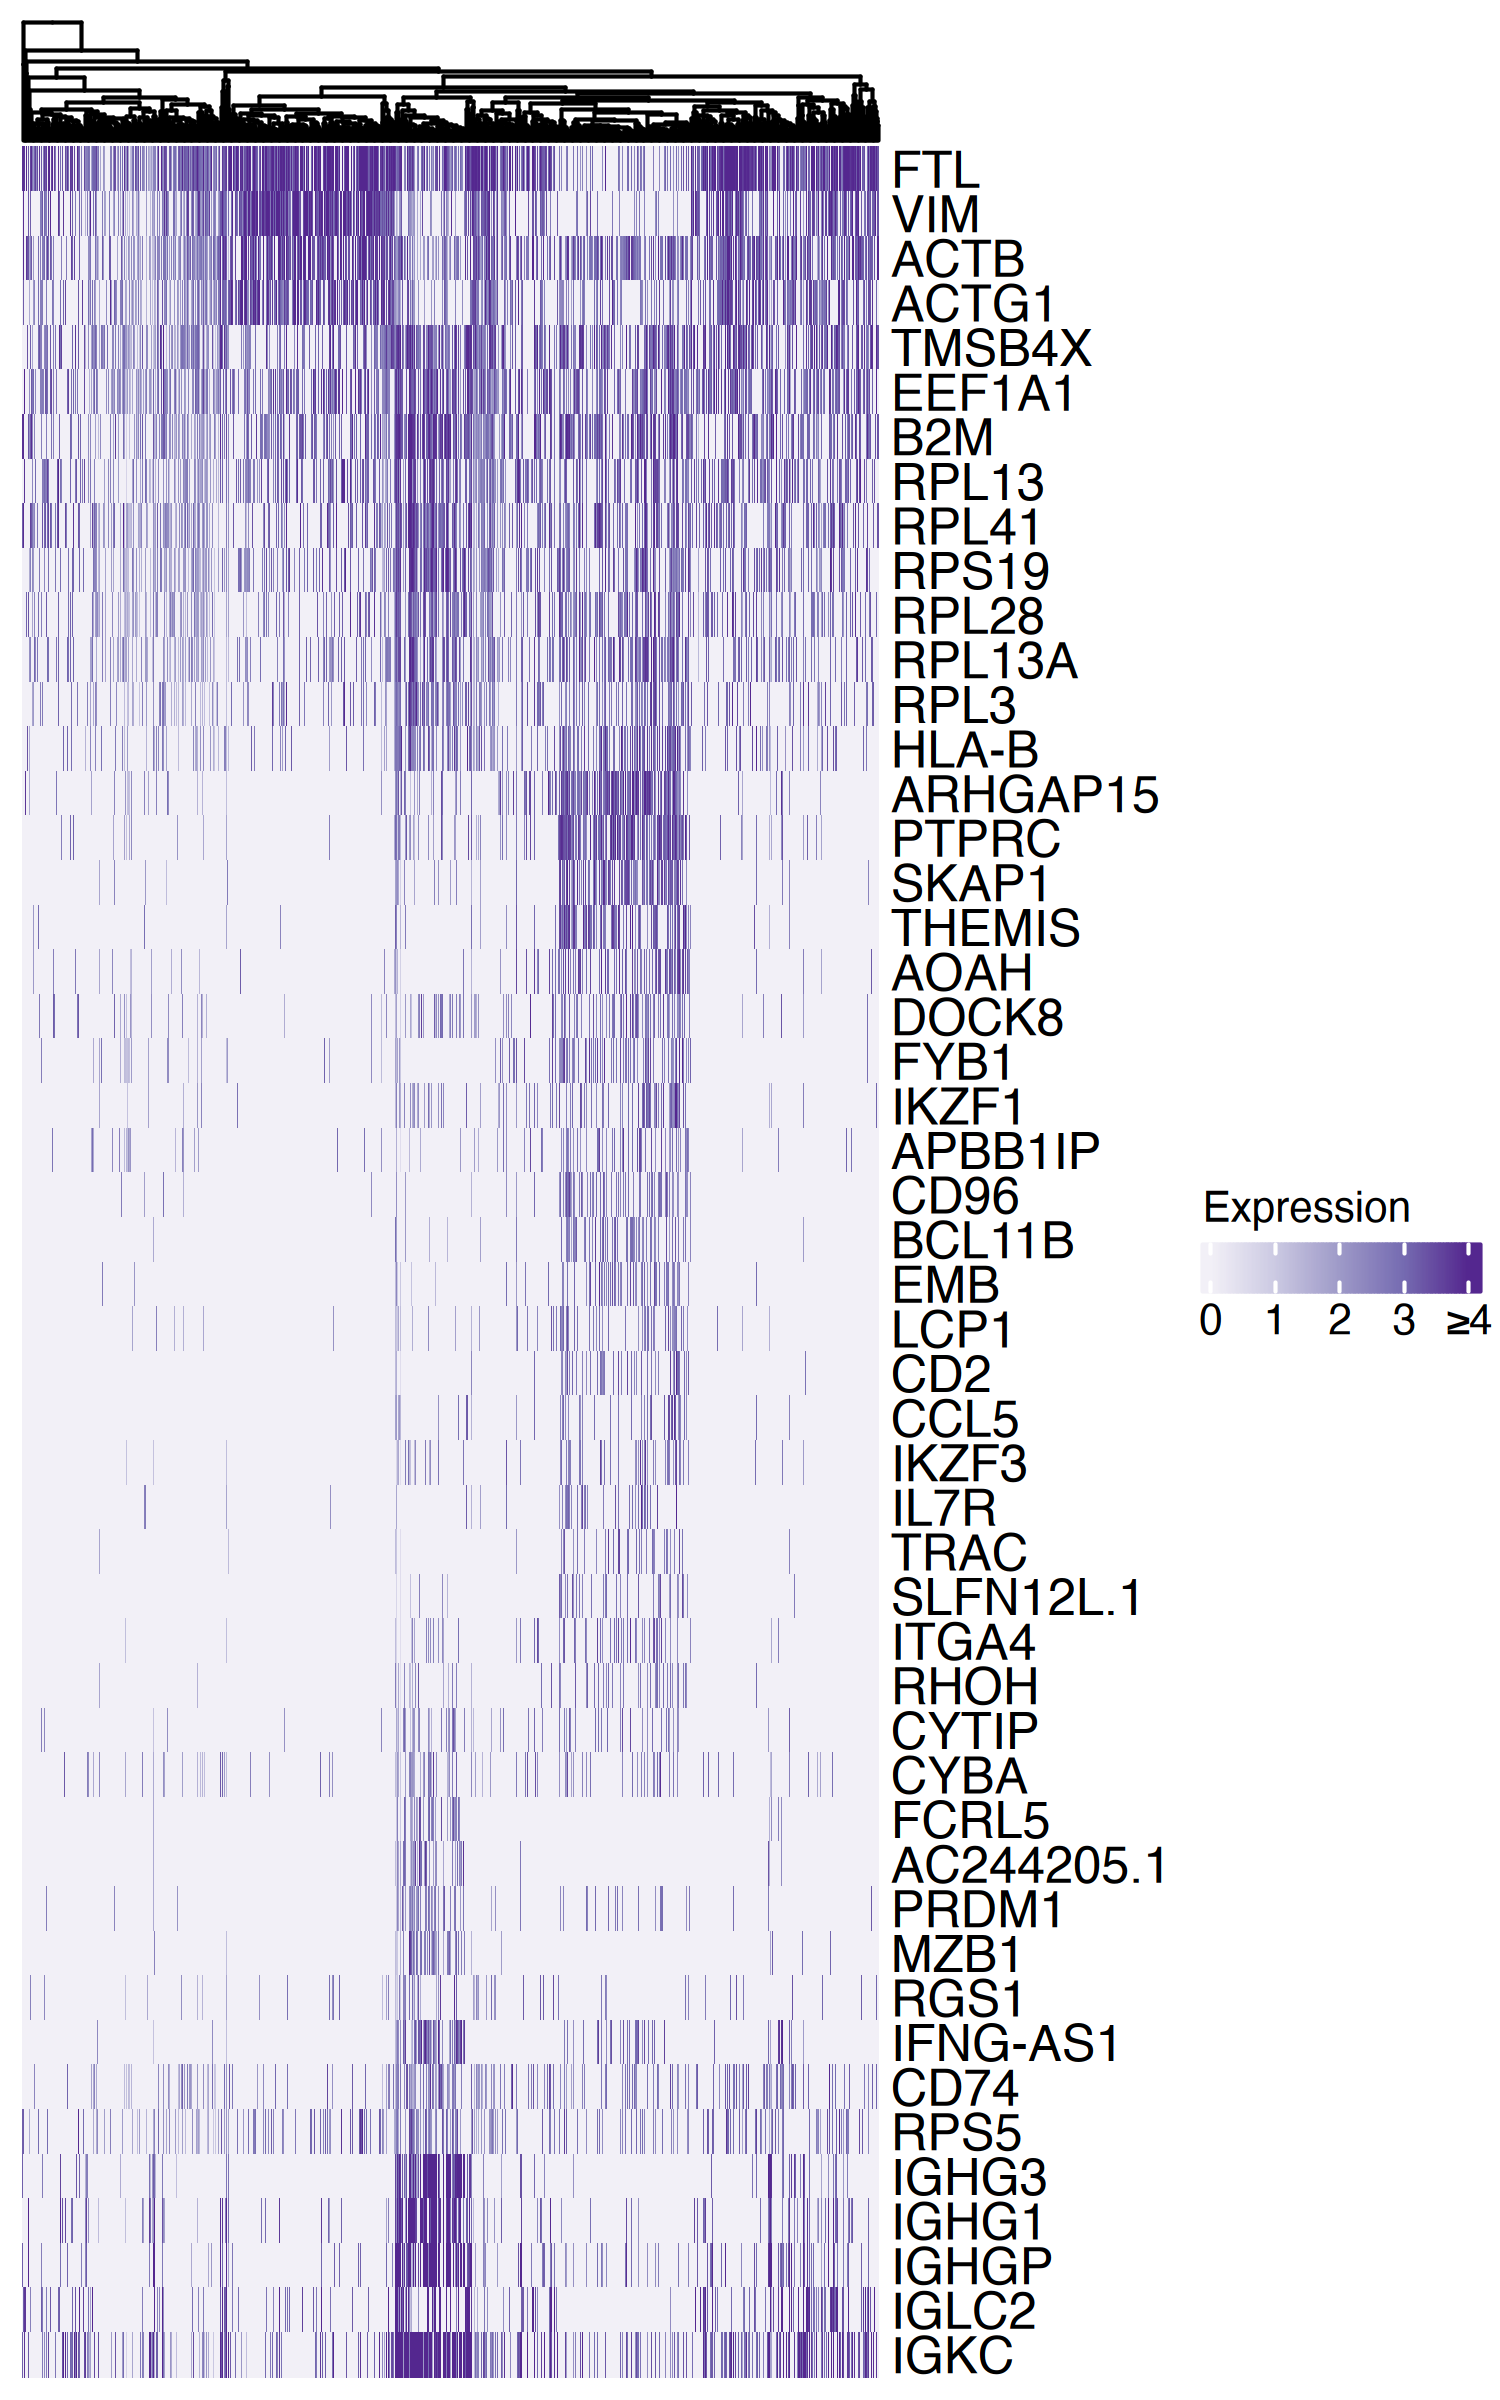

In [21]:
options(repr.plot.width=5, repr.plot.height=8, repr.plot.res = 300, warn = -1)

png("outputs/figures/figure4d.png",width=5,height=8,units="in",res=1200)

ht = Heatmap(name = "Expression", cluster2_heatmap_mat, 
        cluster_columns = dend,
        row_order = rev(get_order(o2, dim = 1)),
        col = circlize::colorRamp2(breaks = c(0, 1, 2, 3, 4), 
                                   colors = RColorBrewer::brewer.pal(n = 5, name = "Purples")), 
        show_column_names = FALSE, 
        row_names_gp = gpar(fontface = "italic"),
        use_raster = FALSE,
       heatmap_legend_param = list(direction="horizontal", labels = c('0', '1', '2', '3', '≥4')))

draw(ht)

dev.off()

ht

options(warn = 0)

Lastly, let's examine the expression of the FIND-seq gene signature across all clusters in the dataset. To visualize sample heterogeneity, we'll first group nuclei into sample-cluster pseudobulks.

In [22]:
ag_human = AggregateExpression(human, assays = 'RNA', group.by = c('seurat_clusters', 'sample'), return.seurat = TRUE)
pseudobulk_mat <- LayerData(ag_human, assay = 'RNA', layer = 'data', features = findseq_human)

Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.
First group.by variable `seurat_clusters` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.
Centering and scaling data matrix



Now plot the heatmap:

pdf 
  2

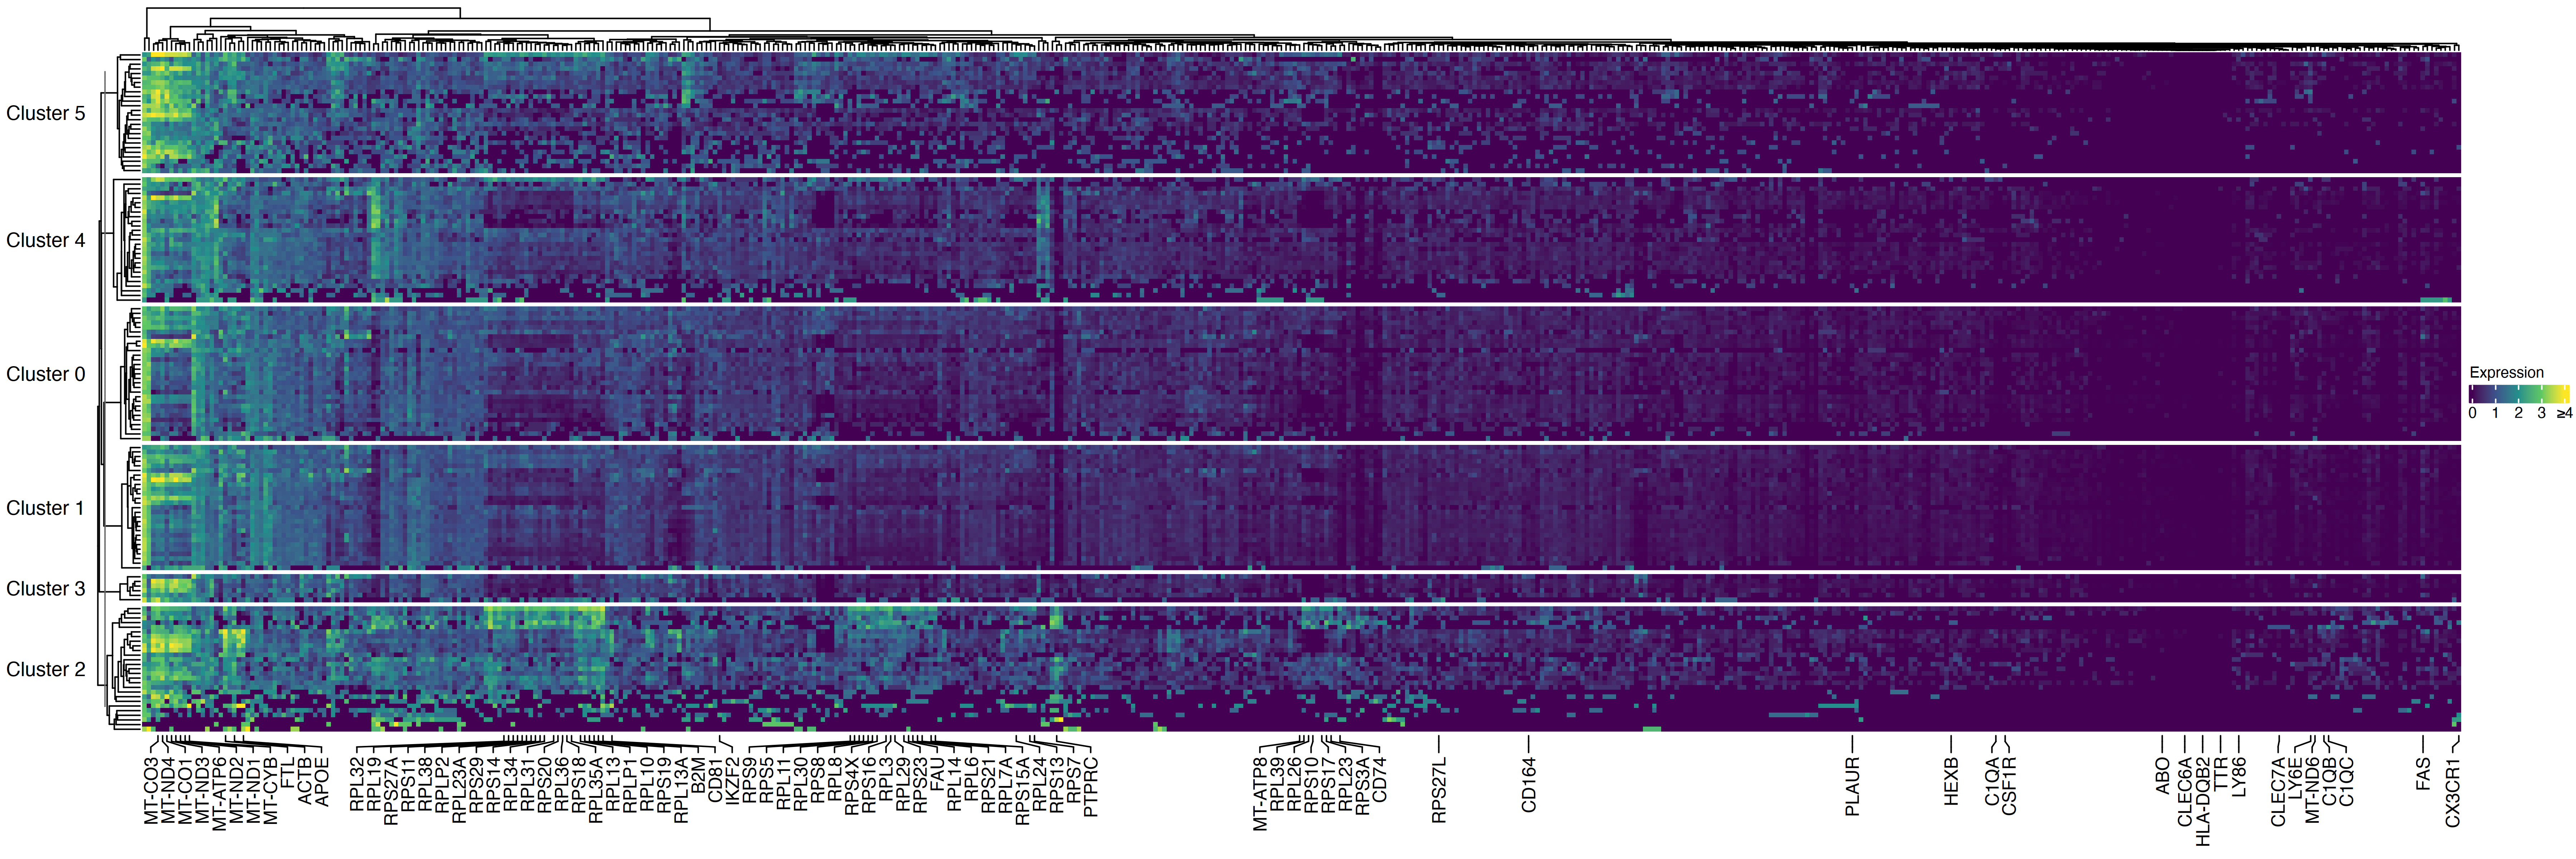

In [23]:
options(repr.plot.width=24, repr.plot.height=8, repr.plot.res = 300, warn = -1)

labels <- c("FTL", "ACTB", "APOE", "B2M", "ABO", "C1QA", "C1QB", "C1QC", "CD74", "CD164", "CD81", 'CLEC6A', 'CLEC7A', 'CSF1R', 'CSF2R', 'CX3CR1', 'FAS', 'FAU', 'HLA-DQB2', 'HEXB', 'IKZF2', 
            'PTPRC', 'TTR', 'LY6S', 'LY6E', 'LY86', 'PLAUR', 'RPL10', 'RPL11', 'RPL13', 'RPL13A', 'RPL14', 'RPL19', 'RPL23', 'RPL23A', 'RPL24', 'RPL26', 'RPL29', 'RPL3', 'RPL30', 'RPL31', 'RPL32', 'RPL34',
           'RPL35A', 'RPL36', 'RPL38', 'RPL39', 'RPL6', 'RPL7A', 'RPL8', 'RPLP1', 'RPLP2', 'RPS10', 'RPS11', 'RPS13', 'RPS14', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS19', 'RPS20', 'RPS21', 
           'RPS23', 'RPS27A', 'RPS27L', 'RPS29', 'RPS3A', 'RPS4X', 'RPS5', 'RPS7', 'RPS8', 'RPS9', 'MT-ATP6', 'MT-ATP8', 'MT-CO1', 'MT-C02', 'MT-CO3', 'MT-ND1', 'MT-ND2', 'MT-CYB', 'MT-ND3', 'MT-ND4', 'MT-ND6')
indices <- match(labels, colnames(t(pseudobulk_mat)))

ha = columnAnnotation(markers = anno_mark(at = indices, 
    labels = labels, 
    labels_gp = gpar(fontface = "italic"), side = "right"))

png("outputs/figures/supplementary_figure3.png",width=24,height=8,units="in",res=1200)

ht <- Heatmap(name = 'Expression', t(pseudobulk_mat), col = circlize::colorRamp2(breaks = c(0, 1, 2, 3, 4), colors = viridis(option = 'viridis', n = 5)),
        bottom_annotation = ha, show_column_names = FALSE,
       row_split = gsub("g", "Cluster ", ag_human$seurat_clusters), 
              row_title_rot = 0, 
              show_row_names = FALSE,
      heatmap_legend_param = list(direction = 'horizontal', at = c(0, 1, 2, 3, 4), labels = c('0', "1", "2", "3", "≥4")))

draw(ht)

dev.off()

ht

options(warn = 0)

In [24]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/libopenblasp-r0.3.28.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrastr_1.0.2         cowplot_1.1.3         harmony_1.2.3        
 [4] svglite_2.1.3         Matrix_1.6-5          ggrepel_0.9.6        
 [7] seriation_1.5.7       dendextend_1.19.0     ComplexHeatmap_2.18.0
[10] orthogene_1.8.0       presto_1.0.0          data.table_1.15.4    
[13] Rcpp_1.0.13-1         viridis_0.6.5         viridisLite_0.4.2    
[16] tidyr_1.3.1           dplyr_1.1.4           ggpubr_0.6.0         
[19] ggplot2_3.5.1         readxl_1.4.3       

In [25]:
version

               _                           
platform       x86_64-apple-darwin13.4.0   
arch           x86_64                      
os             darwin13.4.0                
system         x86_64, darwin13.4.0        
status                                     
major          4                           
minor          3.3                         
year           2024                        
month          02                          
day            29                          
svn rev        86002                       
language       R                           
version.string R version 4.3.3 (2024-02-29)
nickname       Angel Food Cake             